\begin{center}
\large{\textbf{UNIVERZITET U BEOGRADU}}\\
[0.26cm]
\textsc\huge{\textbf{ELEKTROTEHNIČKI FAKULTET}}\\
[2cm]
\line(1,0){300}\\
[0.25in]
\LARGE\bfseries{13E044DOS DIGITALNA OBRADE SLIKE}\\
[2mm]
\huge\bfseries{PRVI DOMAĆI}\\
[2mm]
\line(1,0){200}\\
[1.5cm]
\textsc\LARGE{Marko Macura}\\
\LARGE{0261/2018}\\
[7cm]
\textsc{\large{Beograd}}
\end{center}

# Zadatak 1

In [1]:
from pylab import *
import skimage
from skimage import io
from skimage import filters
from skimage import color
from scipy import ndimage
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import math
import os, sys

U nastavku je kod koji radi Canny-jev algoritam. Prikazao sam slike svih međukoraka. Uradio sam kao po uputstvu iz teksta zadatka. Prvo što je potrebno uraditi je Gauss-ovo filtriranje, da bi se otklonio šum da bismo smanjili broj detektovanih ivica zbog šuma. Nakon toga je potrebno odrediti gradijente pomoću Sobelovih matrica. Dalje sam odredio magnitudu i ugao. Pošto dobijamo magnitudu koja ima više od 1 piksela, a kako je nama potreban samo jedan piksel za ivicu, određujemo lokalne maksimume koji idu u pravcu gradijenta. Kako ne možemo za sve uglove gradijenta da odradimo to, delimo na delove koje treba napadati horizontalnom, vertikalnom, pod 45 stepeni i pod -45 stepeni. Nakon toga određujemo sve te ivice i delimo ih na jake i slabe. Jake ivice su ivice koje su veće od gornjeg thresholda. Ukoliko nam je gradijent premali to može da bude rezultat šuma i zbog toga ne razmatramo piksele koji su manji od donje granice, a ukoliko je između gornje i donje granice tada te piksele smatramo slabim. Za piksele, koji su iznad gornje granice, smo sigurni da su ivični, odnosno da nismo uhvatili šum. Za piksele koji su između dve granice nismo sigurni da li su rezultat šuma ili su deo ivice, pa zbog toga gledamo da li u njihovoj okolini postoji neki jak piksel, i ukoliko postoji onda i ovaj piksel smatramo jakim. Ovaj proces ponavljamo sve dok nam slika ne uđe u stacionarno stanje. Za piksele manje od donje granice smatramo da su rezultat šuma, pa ih ni ne uzimamo u obzir.

<ipython-input-2-b88ed047cad1>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_in = color.rgb2gray(img_in)


Text(0.5, 1.0, 'Izlaz')

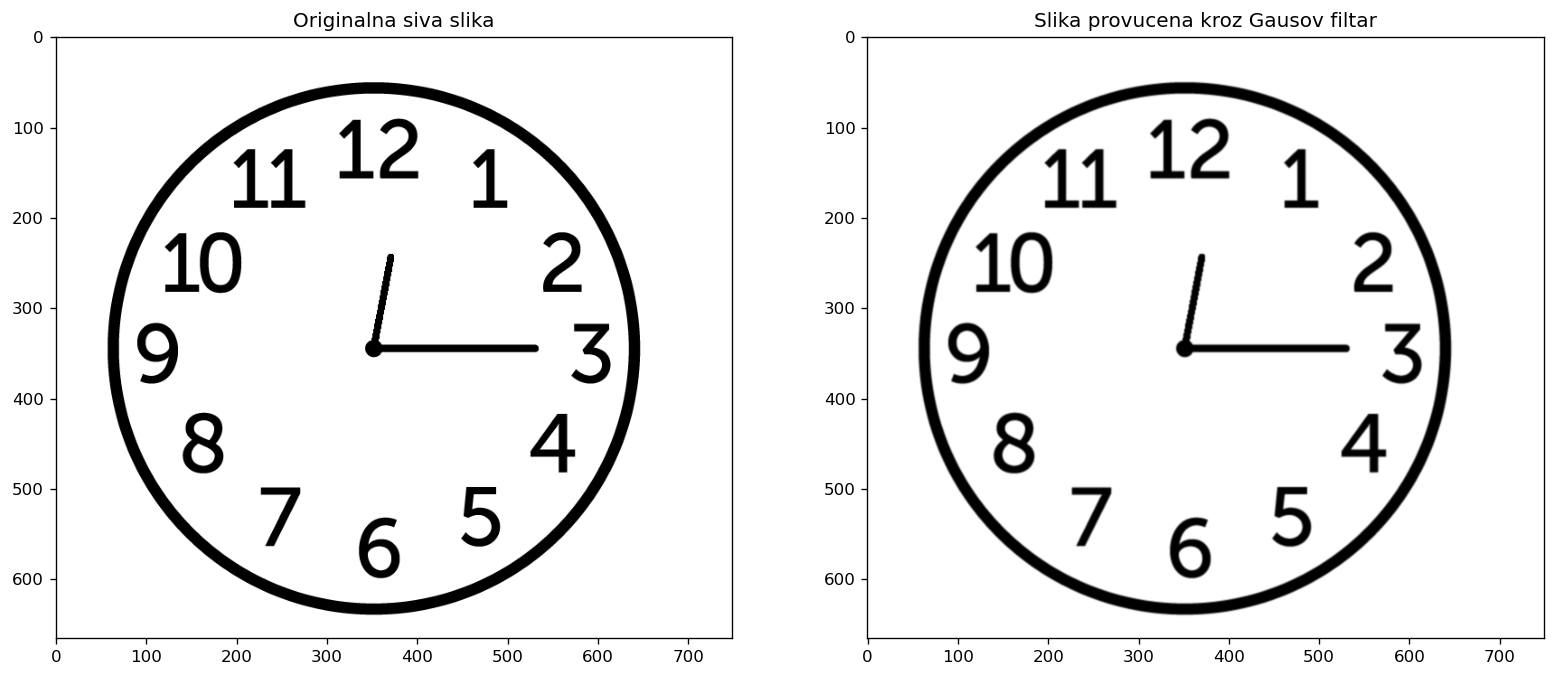

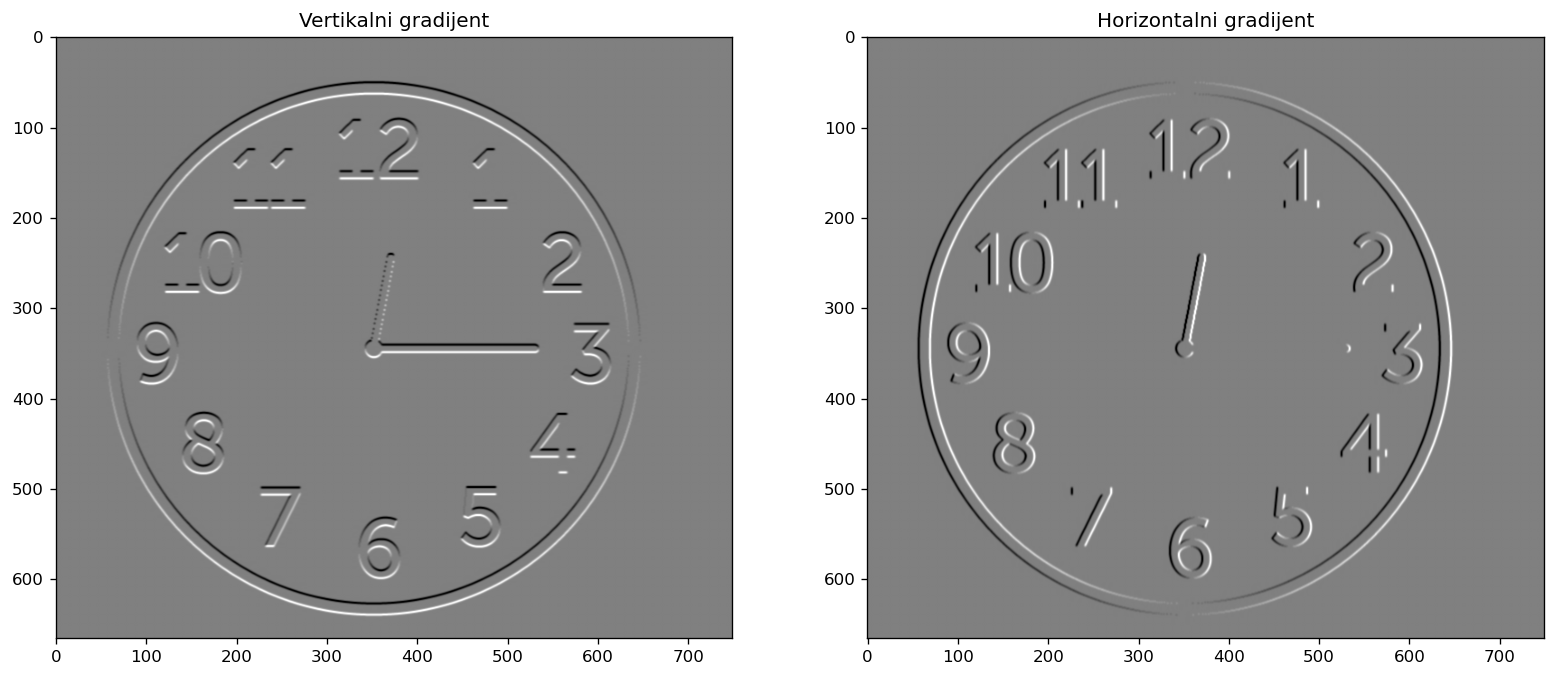

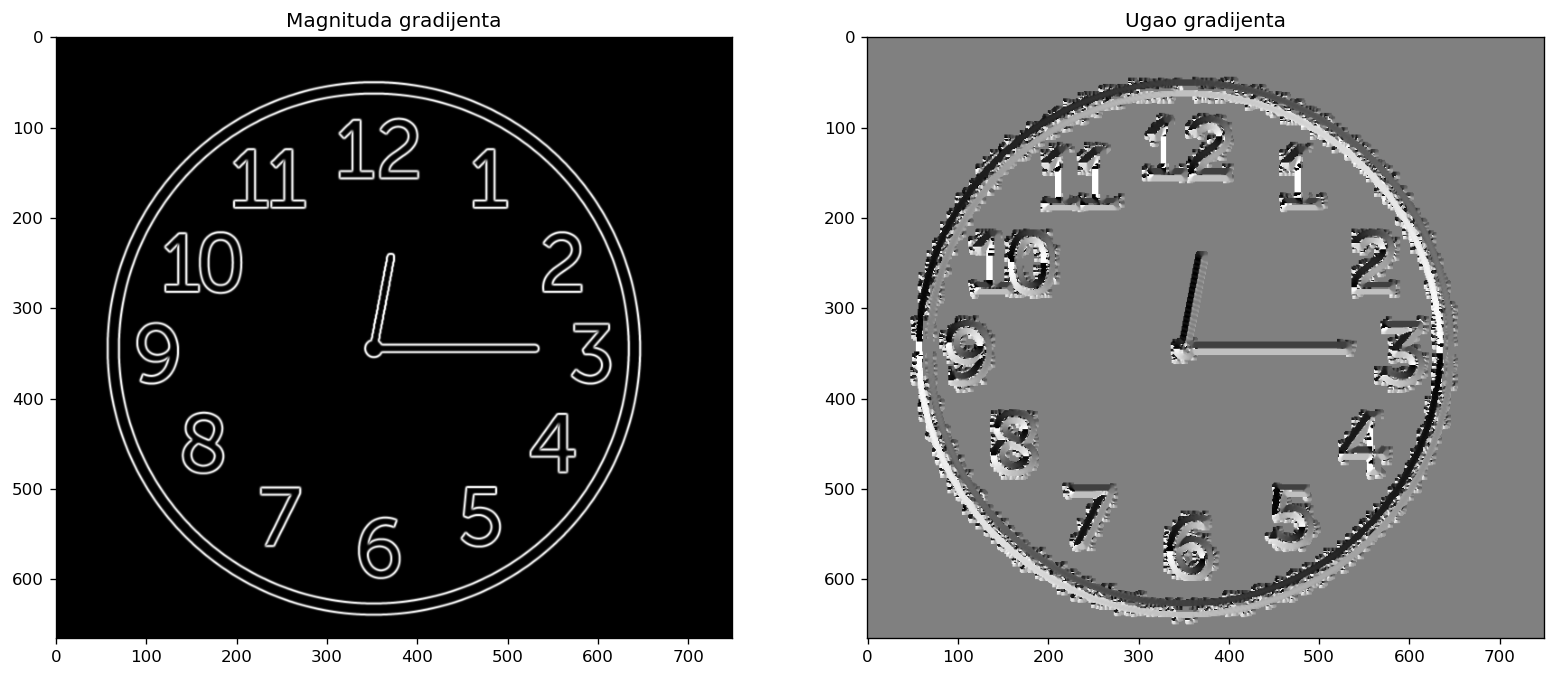

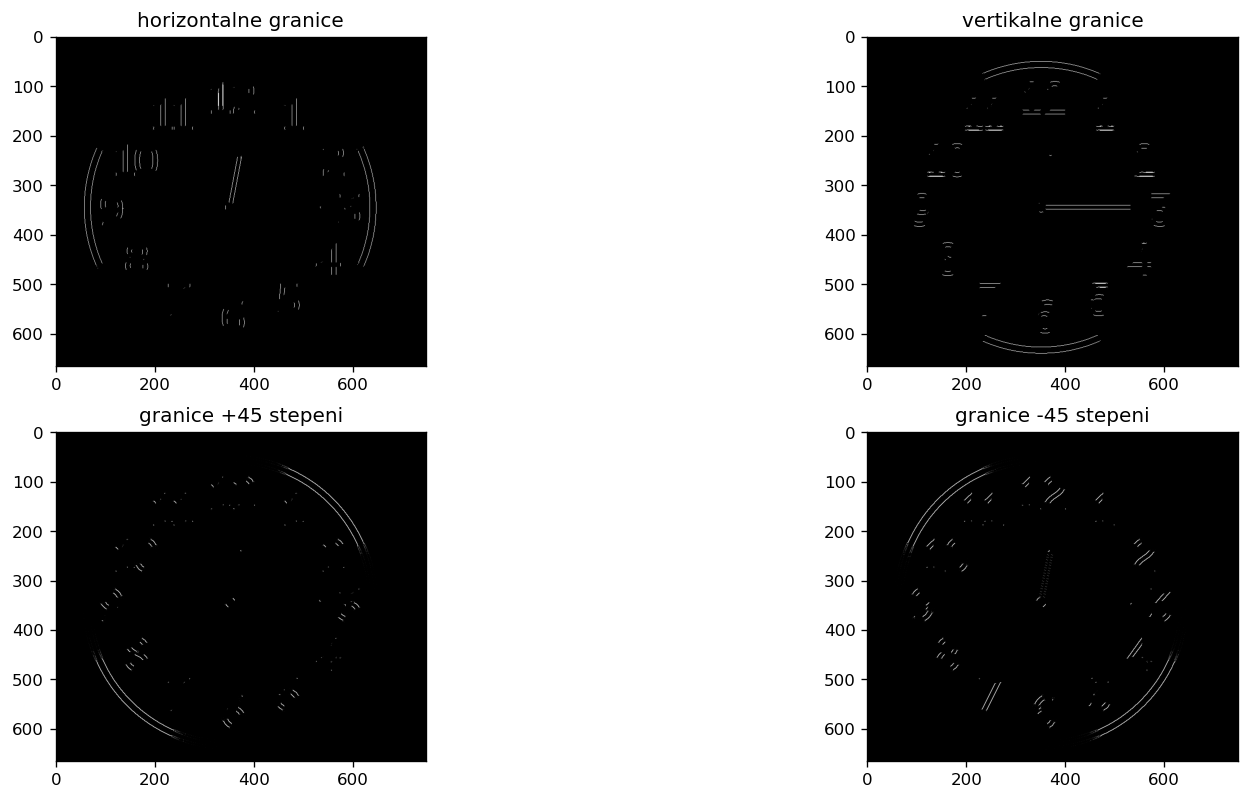

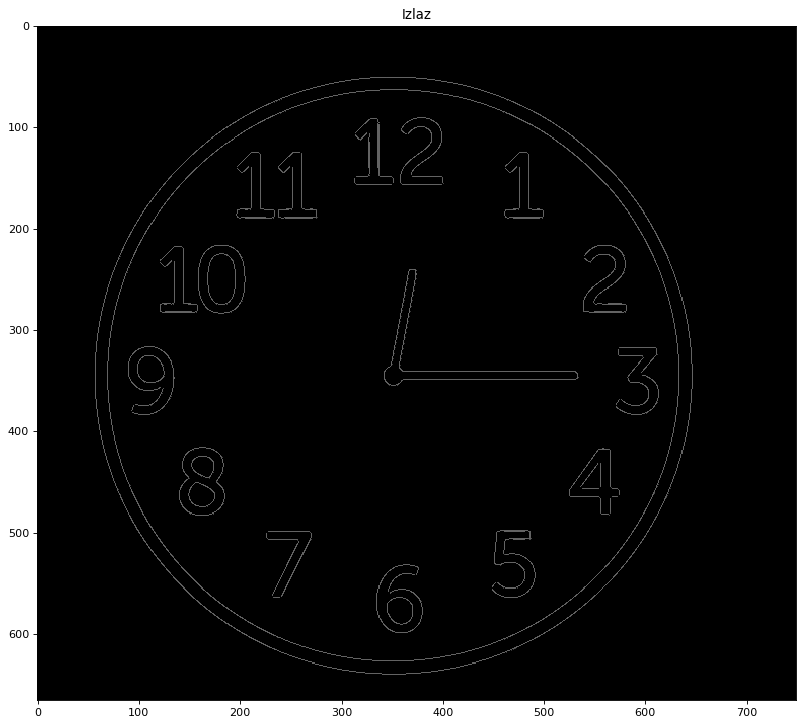

In [2]:
img_in = imread('../sekvence/clocks/clock1.png')

img_in = color.rgb2gray(img_in)
img_in = skimage.img_as_float(img_in)

sigma = 0.7
threshold_low = 0.2
threshold_high = 0.35

# filtering the input image
img = filters.gaussian(img_in, sigma=sigma, truncate=3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(img_in, cmap='gray'); ax[0].set_title('Originalna siva slika')
ax[1].imshow(img, cmap='gray'); ax[1].set_title('Slika provucena kroz Gausov filtar')

# gradients
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])/8
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])/8

gradient_vertical = ndimage.correlate(img, sobel_vertical)
gradient_horizontal = ndimage.correlate(img, sobel_horizontal)
# vertical gradient
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(gradient_vertical, cmap='gray'); ax[0].set_title('Vertikalni gradijent')

# horizontal gradient
ax[1].imshow(gradient_horizontal, cmap='gray'); ax[1].set_title('Horizontalni gradijent')

# calculating magnitude and angle
magnitude = np.sqrt(np.square(gradient_vertical) +
                    np.square(gradient_horizontal))
angle = np.rad2deg(np.arctan2(gradient_vertical, gradient_horizontal))

# magnitude
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(magnitude, cmap='gray'); ax[0].set_title('Magnituda gradijenta')
ax[1].imshow(angle, cmap='gray'); ax[1].set_title('Ugao gradijenta')

# quantization
horizontal = ((angle > -22.5) * (angle < 22.5) +
              (angle < -157.5) + (angle > 157.5))

vertical = ((angle > 67.5) * (angle < 112.5)) + \
    ((angle < -67.5) * (angle > -112.5))

diag45 = ((angle > 112.5) * (angle < 157.5)) + \
    ((angle < -22.5) * (angle > -67.5))

diag_45 = ((angle > 22.5) * (angle < 67.5)) + \
    ((angle < -112.5) * (angle > -157.5))

# determining horizontal edges
img_horizontal = horizontal * magnitude
edges_horizontal = np.copy(img_horizontal)
for i in range(1, img_horizontal.shape[0]-1):
    for j in range(1, img_horizontal.shape[1]-1):
        if img_horizontal[i, j] < img_horizontal[i, j-1] or img_horizontal[i, j] < img_horizontal[i, j+1]:
            edges_horizontal[i, j] = 0

# determining vertical edges
img_vertical = vertical * magnitude
edges_vertical = np.copy(img_vertical)
for i in range(1, img_vertical.shape[0]-1):
    for j in range(1, img_vertical.shape[1]-1):
        if img_vertical[i, j] < img_vertical[i-1, j] or img_vertical[i, j] < img_vertical[i+1, j]:
            edges_vertical[i, j] = 0

# determining -45 degrees edges
img_45 = diag_45 * magnitude
edges_45 = np.copy(img_45)
for i in range(1, img_45.shape[0]-1):
    for j in range(1, img_45.shape[1]-1):
        if img_45[i, j] < img_45[i-1, j-1] or img_45[i, j] < img_45[i+1, j+1]:
            edges_45[i, j] = 0

# determining +45 degrees edges
img45 = diag45 * magnitude
edges45 = np.copy(img45)
for i in range(1, img45.shape[0]-1):
    for j in range(1, img45.shape[1]-1):
        if img45[i, j] < img45[i-1, j+1] or img45[i, j] < img45[i+1, j-1]:
            edges45[i, j] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(edges_horizontal, cmap='gray'); ax[0].set_title('horizontalne granice')
ax[1].imshow(edges_vertical, cmap='gray'); ax[1].set_title('vertikalne granice')
ax[2].imshow(edges45, cmap='gray'); ax[2].set_title('granice +45 stepeni')
ax[3].imshow(edges_45, cmap='gray'); ax[3].set_title('granice -45 stepeni')

edges = edges_horizontal + edges_vertical + edges45 + edges_45

# limiting the output
output = edges > threshold_high
check = ~output*(edges > threshold_low)

num = np.sum(output)
num1 = num-1
# adding weak edges
while num != num1:
    num1 = num
    for i in range(check.shape[0]):
        for j in range(check.shape[1]):
            if check[i, j] == True:
                pom = False
                for k in range(-1, 2):
                    for l in range(-1, 2):
                        if output[i+k, j+l]:
                            output[i, j] = True
                        if pom == False:
                            break
                    if pom == False:
                        break
    num = np.sum(output)
    check = ~output*(edges > threshold_low)
plt.figure(figsize=(12, 9), dpi=80)
io.imshow(output*magnitude, cmap='gray'); plt.title('Izlaz')

Sada funkcija koja radi sve isto kao prethodni kod, samo bez plotova, kako bi algoritam bio brži i pregledniji.

In [3]:
def canny_edge_detection(img_in: np.array, sigma: float, threshold_low: float, threshold_high: float) -> np.array:
    # filtering the input image
    img = filters.gaussian(img_in, sigma=sigma, truncate=3)
    
    # gradients
    sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])/8
    sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])/8

    gradient_vertical = ndimage.correlate(img, sobel_vertical)
    gradient_horizontal = ndimage.correlate(img, sobel_horizontal)

    # calculating magnitude and angle
    magnitude = np.sqrt(np.square(gradient_vertical) +
                        np.square(gradient_horizontal))
    angle = np.rad2deg(np.arctan2(gradient_vertical, gradient_horizontal))

    # quantization
    horizontal = ((angle > -22.5) * (angle < 22.5) +
                  (angle < -157.5) + (angle > 157.5))

    vertical = ((angle > 67.5) * (angle < 112.5)) + \
        ((angle < -67.5) * (angle > -112.5))

    diag45 = ((angle > 112.5) * (angle < 157.5)) + \
        ((angle < -22.5) * (angle > -67.5))

    diag_45 = ((angle > 22.5) * (angle < 67.5)) + \
        ((angle < -112.5) * (angle > -157.5))

    # determining horizontal edges
    img_horizontal = horizontal * magnitude
    edges_horizontal = np.copy(img_horizontal)
    for i in range(1, img_horizontal.shape[0]-1):
        for j in range(1, img_horizontal.shape[1]-1):
            if img_horizontal[i, j] < img_horizontal[i, j-1] or img_horizontal[i, j] < img_horizontal[i, j+1]:
                edges_horizontal[i, j] = 0

    # determining vertical edges
    img_vertical = vertical * magnitude
    edges_vertical = np.copy(img_vertical)
    for i in range(1, img_vertical.shape[0]-1):
        for j in range(1, img_vertical.shape[1]-1):
            if img_vertical[i, j] < img_vertical[i-1, j] or img_vertical[i, j] < img_vertical[i+1, j]:
                edges_vertical[i, j] = 0

    # determining -45 degrees edges
    img_45 = diag_45 * magnitude
    edges_45 = np.copy(img_45)
    for i in range(1, img_45.shape[0]-1):
        for j in range(1, img_45.shape[1]-1):
            if img_45[i, j] < img_45[i-1, j-1] or img_45[i, j] < img_45[i+1, j+1]:
                edges_45[i, j] = 0

    # determining +45 degrees edges
    img45 = diag45 * magnitude
    edges45 = np.copy(img45)
    for i in range(1, img45.shape[0]-1):
        for j in range(1, img45.shape[1]-1):
            if img45[i, j] < img45[i-1, j+1] or img45[i, j] < img45[i+1, j-1]:
                edges45[i, j] = 0

    edges = edges_horizontal + edges_vertical + edges45 + edges_45

    # limiting the output
    output = edges > threshold_high
    check = ~output*(edges > threshold_low)

    num = np.sum(output)
    num1 = num-1
    # adding weak edges
    while num != num1:
        num1 = num
        for i in range(check.shape[0]):
            for j in range(check.shape[1]):
                if check[i, j] == True:
                    pom = False
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            if output[i+k, j+l]:
                                output[i, j] = True
                            if pom == False:
                                break
                        if pom == False:
                            break
        num = np.sum(output)
        check = ~output*(edges > threshold_low)
    return output*magnitude

Ukoliko ne bismo otklonili šum, moramo da stavimo gornji prag da bude visok kako bismo izbegli šum u okviru detekcije. Na sledećem primeru neću staviti gornju granicu i neću otkloniti šum. Kao što se vidi na nekim delovima postoje ivice koje ne postoje na originalnoj slici. 

Text(0.5, 1.0, 'Izlaz Canny-jevog algoritma za malo sigma i mali gornji prag')

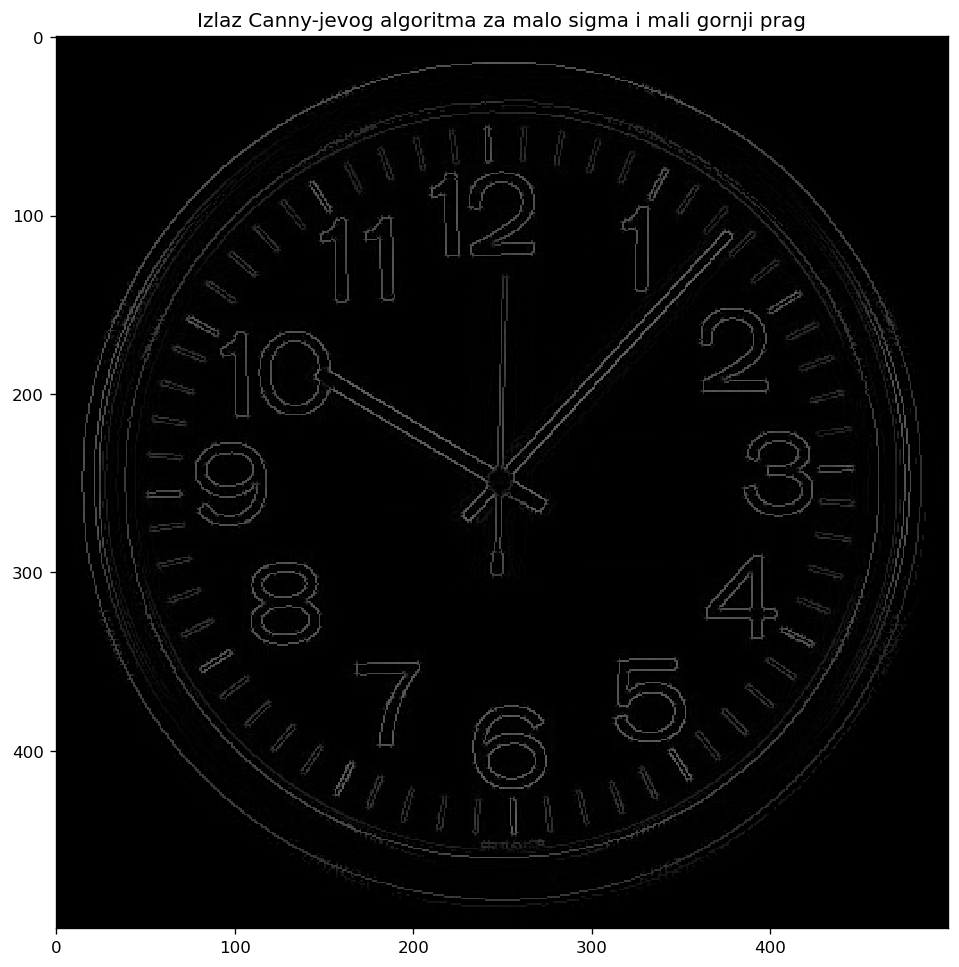

In [4]:
img_in = imread('../sekvence/clocks/clock7.jpg')

img_in = color.rgb2gray(img_in)
img_in = skimage.img_as_float(img_in)
out = canny_edge_detection(img_in, 0, 0, 0)
plt.figure(figsize=(16,8), dpi=120)
io.imshow(out); plt.title('Izlaz Canny-jevog algoritma za malo sigma i mali gornji prag')

Gornja granica je isto dobra za otklanjanje nerelevantnih delova slike, na primer ove crtice za minute između brojeva.

Text(0.5, 1.0, 'Uticaj gornjeg praga na nerelevantne delove slike')

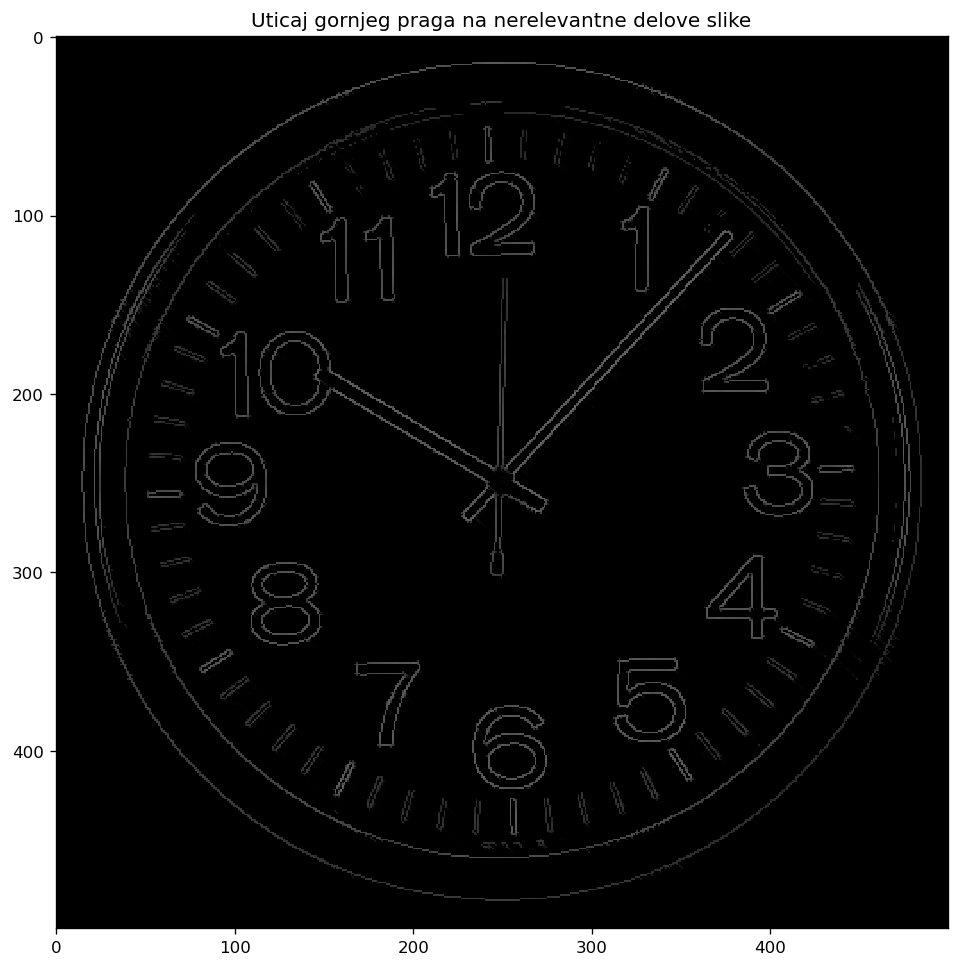

In [5]:
out = canny_edge_detection(img_in, 0.3, 0, 0.15)
plt.figure(figsize=(16,8), dpi=120)
io.imshow(out); plt.title('Uticaj gornjeg praga na nerelevantne delove slike')

Text(0.5, 1.0, 'Uticaj gornjeg praga na nerelevantne delove slike')

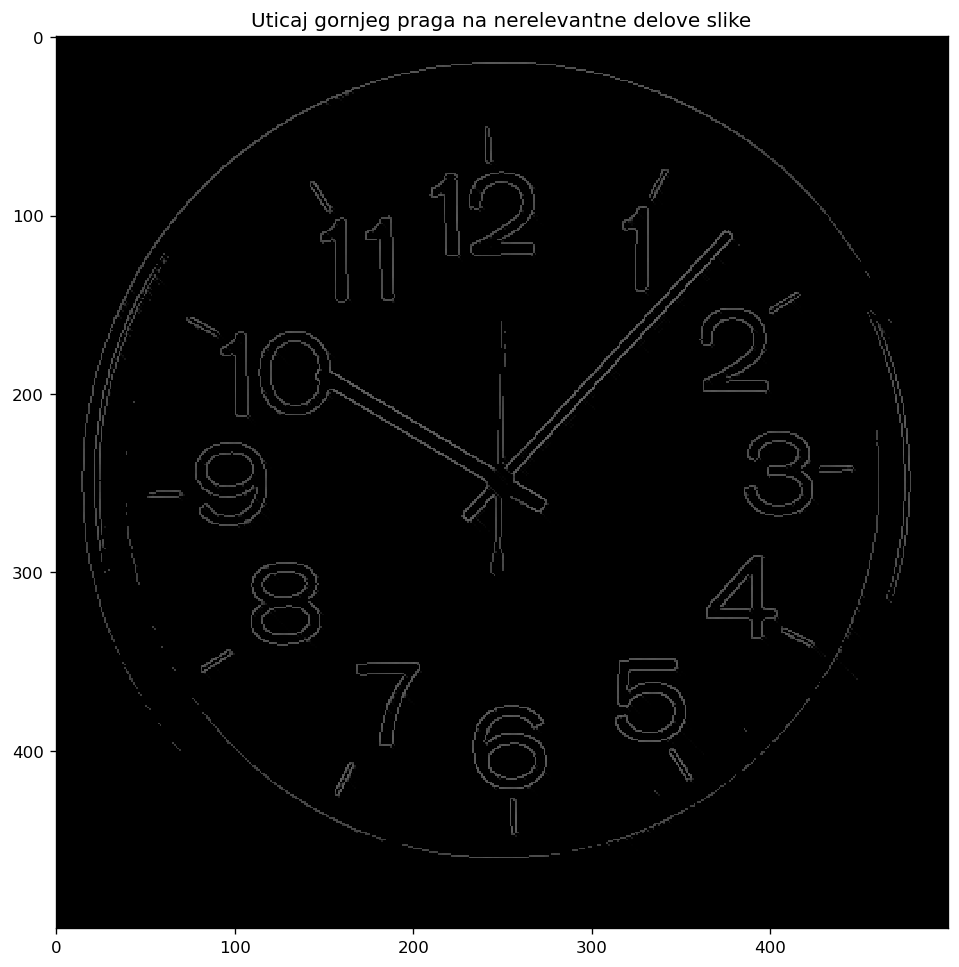

In [6]:
out = canny_edge_detection(img_in, 0.3, 0, 0.25)
plt.figure(figsize=(16,8), dpi=120)
io.imshow(out); plt.title('Uticaj gornjeg praga na nerelevantne delove slike')

Sledeća funkcija određuje krajnja temena duži. Prilikom rada ove funkcije napravio sam funkciju prave kroz koju treba da odredim duži. Nakon toga, u zavisnosti od ugla $\theta$ sam gledao kroz koju osu bi trebalo da prolazim, jer mi ugao određuje i nagib. Kako nam ugrađena funkcija vraća $90 - \theta$ gde je $\theta$ ugao između vertikalne ose i normale na pravu, tada ukoliko je taj ugao između -45 i 45 gledamo horizontalnu osu, inače gledamo vertikalnu.

In [7]:
def get_line_segments(img_edges: np.array, line: np.array, min_size: int, max_gaps: int, tolerancy: int) -> tuple:
    theta = line[0]
    rho = line[1]
    
    originy = np.arange(tolerancy, img_edges.shape[0]-tolerancy)
    originx = np.arange(tolerancy, img_edges.shape[1]-tolerancy)
    
    # values that we should go throught depending on the angle theta
    x = np.round((rho - originx * np.cos(theta)) / np.sin(theta))
    x = x.astype(int)
    y = np.round((rho - originy * np.sin(theta)) / np.cos(theta))
    y = y.astype(int)
    
    line_start = [-1, -1]
    line_stop = [-1, -1]
    length = 0
    ok = False
    gap_len = 0
    lines = []
    if not (theta<deg2rad(45) and theta>deg2rad(-45)):
        for i in range(x.size):
            # including the tolerancy
            first = np.arange(x[i]-tolerancy, x[i]+tolerancy+1)
            second = np.arange(originx[i]-tolerancy, originx[i]+tolerancy+1)
            
            second = second[first>=0]
            first = first[first>=0]
            
            second = second[first<img_edges.shape[0]]
            first = first[first<img_edges.shape[0]]
            
            mat = img_edges[first, second]
            mat = mat>0
            # if anz pixel is different than 0 count this pixcel as a part of the edge
            if np.any(mat) and mat.size>0:
                if ok == False:
                    line_start = np.array([x[i], originx[i]])
                    ok = True
                line_stop = np.array([x[i], originx[i]])
                length = length + 1 + gap_len
                gap_len = 0
            else:
                if ok == True:
                    gap_len = gap_len + 1
            
            # if enough pixcels is not classified as edge, add to the list the starting and ending pixcel
            if gap_len > max_gaps:
                ok=False
                gap_len = 0
                if length > min_size:
                    lines = lines + [[line_start, line_stop]]
                length = 0
    else:
        for i in range(y.size):
            # including the tolerancy
            first = np.arange(originy[i]-tolerancy, originy[i]+tolerancy+1)
            second = np.arange(y[i]-tolerancy, y[i]+tolerancy+1)
            
            first = first[second>=0]
            second = second[second>=0]
            
            first = first[second<img_edges.shape[1]]
            second = second[second<img_edges.shape[1]]
            
            mat = img_edges[first, second]
            mat = mat>0
            # if anz pixel is different than 0 count this pixcel as a part of the edge
            if np.any(mat):
                if ok == False:
                    line_start = np.array([originy[i], y[i]])
                    ok = True
                line_stop = np.array([originy[i], y[i]])
                length = length + 1 + gap_len
                gap_len = 0
            else:
                if ok == True:
                    gap_len = gap_len + 1
            # if enough pixcels is not classified as edge, add to the list the starting and ending pixcel
            if gap_len > max_gaps:
                ok=False
                gap_len = 0
                if length > min_size:
                    lines = lines + [[line_start, line_stop]]
                length = 0
    return lines

Sledeća funkcija služi za testiranje funkcije get_line_segments. Ona plotuje linije koje get_line_segments vrati.

In [8]:
def plot_lines(img_in: np.array, min_size: int, max_gaps: int, tolerancy: int) -> None:
    canny =  canny_edge_detection(img_in, 0.7, 0.1, 0.2)

    [out, angles, distances] = skimage.transform.hough_line(canny)
    [intensity, peak_angles, peak_distances] = skimage.transform.hough_line_peaks(out, angles=angles, dists=distances, min_distance=20, threshold=0.4*amax(out), num_peaks=5)

    fix, axes = plt.subplots(1, 1, figsize=(20, 8))
    axes.imshow(canny, cmap=plt.cm.gray)
    axes.set_title('min_size=' + str(min_size) + ", max_gaps=" + str(max_gaps) + ", tolerancy=" + str(tolerancy))
    for _, angle, dist in zip(intensity, peak_angles, peak_distances):
        lines = get_line_segments(canny, np.array([angle, dist]), min_size, max_gaps, tolerancy)
        for line in lines:
            origin = np.array([line[0][1], line[1][1]])
            y0, y1 = line[0][0], line[1][0]
            axes.plot(origin, (y0, y1), '-r')
    axes.set_axis_off()
    plt.show()

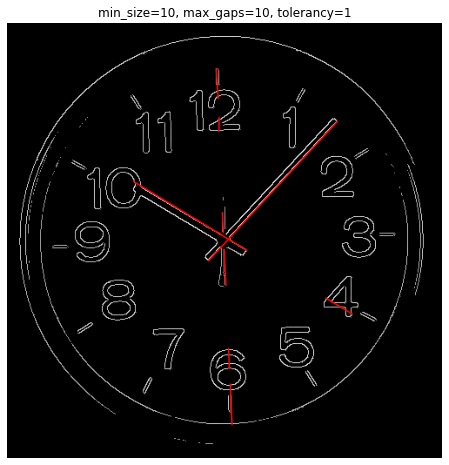

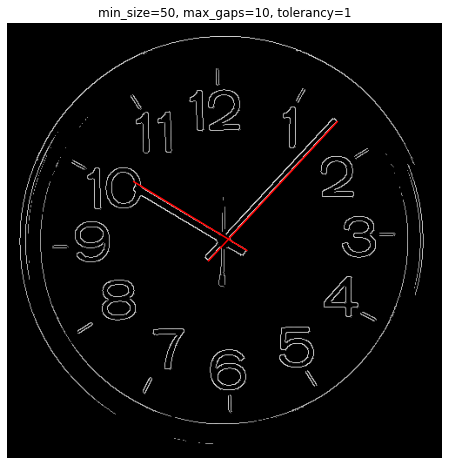

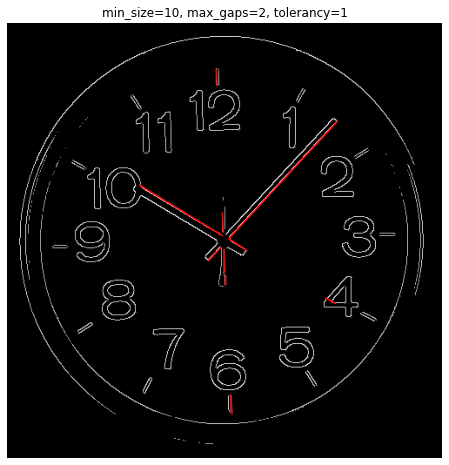

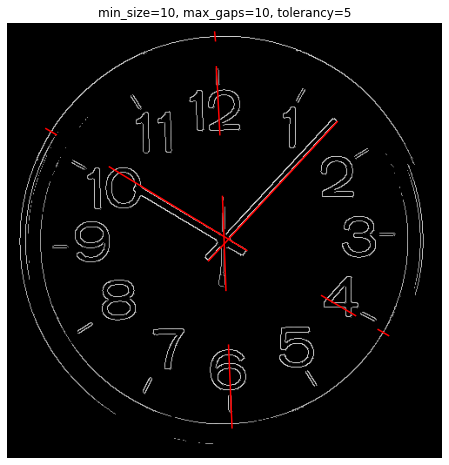

In [9]:
img_in = imread('../sekvence/clocks/clock7.jpg')

img_in = color.rgb2gray(img_in)
img_in = skimage.img_as_float(img_in)
plot_lines(img_in, 10, 10, 1)
plot_lines(img_in, 50, 10, 1)
plot_lines(img_in, 10, 2, 1)
plot_lines(img_in, 10, 10, 5)

U prethodnoj sekvenci koda pokazao sam kako se get_line_segments funkcija ponaša kada joj zadamo različite parametre. Ako joj zadamo premalo min_size, ona registruje neke duži koje nam nisu koristne. Kako su kazaljke dosta duže od ostalih linija možemo taj parametar da stavimo da bude dosta veći od ovih 10 koje sam postavio na početku. To vidimo na drugoj slici kada sam stavio da je taj parametar jednak 50, tada smo dobili samo kazaljke. Kao što vidimo max_gaps nam je 10 na početku što je možda preveliko za taj parametar, jer zbog njega dobijamo neke nepostojeće linije kao što su ove kod četvorke i šetstice. Vidimo da su nam rezultati dosta bolji kada je taj parametar manji, međutim treba biti oprezan oko njega, jer može Gausov filtar dosta da napravi poneku rupu kod ivice za kazaljku i ako nam je max_gaps premali onda ćemo dobiti manju kazaljku nego što želimo, a može da bude i problem u kombinaciji sa min_size parametrom, pa da nekad ni ne detektujemo kazaljku. Što se tiče tolerancy parametra vidimo da taj parametar ne sme da bude velik. Sa tolerancy=5 dobili smo nepostojeće duži, što i nije toliki problem u poređenju sa produživanjem kazaljke koje smo takođe dobili.

U nastavku je funkcija koja vraća tačno vreme (sate i minute). Pošto su kazaljke za sekunde tanke tada ih ili Gausov filtar otkloni, ili su u boji pa imaju manji gradijent i zbog toga limitiram gradijent u jednom trenutku. Sve gradijente koji su manji od $\frac{3 \cdot max(canny)}{4}$ postavljam na 0. Pošto nije na svim slikama sat centriran, brišem sve vertikalne i hotizontalne linije iz canny matrice čija je suma jednaka 0, da bih lakše odredio kazaljke. Koristio sam ugrađene funkcije skimage.transform.hough_line i skimage.transform.hough_line_peaks kako bih odredio prave kojima pripadaju kazaljke. Kada sam dobio sva temena, proveravao sam da li su jedan od ta dva temena blizu centra i ukoliko jeste uzimam ih u obzir kao kazaljke. Tada odredim najdužu i drugu najdužu duž i njih klasifikujem kao kazaljke za minute i sate, respektivno. ![alt text](objasnjenje.png "Objasnjenje"). Na slici je objašnjeno kako sam došao do zaključka da je Theta (izlaz iz ugrađene funkcije) jednako uglu između kazaljki ($\alpha$), što sam kasnije koristio za određivanje vremena.
Još jedan problem je što ugao prave ne određuje jednoznačno koliko sati ima, nego treba odrediti i u kom kvadrantu se nalazi kazaljka. Kako je to sklono greškama, jer kada kazaljka pokazuje na 3 tada je mala granica između gornjeg dela slike i donjeg dela slike i ponekad program vrati tačno a nekad ne, a ponekad i pripada tačno pravoj pa i nemamo tačnu klasifikaciju. Zbog toga sam uveo i da gledam nagib i ukoliko je nagib manji, onda gledam da li se nalazi u levom ili desnom delu slike, a ukoliko je nagib veći onda gledam da li se nalazi u gornjem ili u donjem delu slike. Tako jednoznačno određujem koliko sati i minuta pokazuje sat.

In [10]:
def extract_time(img_in: np.array) -> tuple:
    # determining canny's edges
    canny = canny_edge_detection(img_in, 0.7, 0.1, 0.2)
    
    ok=False
    left = 0
    s = 0
    # deleting rows and colomns which do not have any edge.
    for i in range(canny.shape[0]):
        if np.sum(canny[i, :]) != 0 and ok == False:
            s = i
            ok = True
        if np.sum(canny[i, :]) == 0 and ok == True:
            canny = canny[s:i, :]
            break
    ok=False
    left = 0
    s = 0
    for i in range(canny.shape[1]):
        if np.sum(canny[:, i]) != 0 and ok == False:
            ok = True
            s = i
        if np.sum(canny[:, i]) == 0 and ok == True:
            st = i
            canny = canny[:, s:i]
            break
    # deleting edges with smaller gradient
    canny[canny<np.max(canny)*3/4] = 0

    # Hough algorithm
    [out, angles, distances] = skimage.transform.hough_line(canny)
    [intensity, peak_angles, peak_distances] = skimage.transform.hough_line_peaks(out, angles=angles, dists=distances, min_distance=20, threshold=0.4*amax(out), num_peaks=5)
    
    max1 = -1
    ang1 = -1
    right_half1 = False
    top_half1 = False
    max2 = -1
    ang2 = -1
    right_half2 = False
    top_half2 = False
    
    for _, angle, dist in zip(intensity, peak_angles, peak_distances):
        lines = get_line_segments(canny, np.array([angle, dist]), 60, 20, 1)
        for line in lines:
            # if any end of the line is near center, take this line into consideration
            if not line[0][0] in range(round(canny.shape[0]/2)-30, round(canny.shape[0]/2)+30) and not line[1][0] in range(round(canny.shape[0]/2)-30, round(canny.shape[0]/2)+30):
                if not line[0][1] in range(round(canny.shape[1]/2)-30, round(canny.shape[1]/2)+30) and not line[1][1] in range(round(canny.shape[1]/2)-30, round(canny.shape[1]/2)+30):
                    break
            right_half = False
            top_half = False
            # is the line in the right half of the image
            if (line[0][1] + line[1][1])/2 > canny.shape[1]/2:
                right_half = True
            # is the line in the top half of the image
            if (line[0][0] + line[1][0])/2 < canny.shape[0]/2:
                top_half = True
            # determining the line length and checking if this line is the longest or the second longest
            line_length = sqrt((line[0][0]- line[1][0])**2 + (line[0][1]-line[1][1])**2)
            if max1 == -1:
                max1 = line_length
                ang1 = angle
                right_half1 = right_half
                top_half1 = top_half
            else:
                if max1 > line_length and max2 < line_length:
                    max2 = line_length
                    ang2 = angle
                    right_half2 = right_half
                    top_half2 = top_half
            if line_length> max1:
                max2 = max1
                ang2 = ang1
                right_half2 = right_half1
                top_half2 = top_half1
                max1 = line_length
                ang1 = angle
                right_half1 = right_half
                top_half1 = top_half
    # if there are no second longest line, then the longest line is for minutes and hours
    if max2 == -1:
        max2 = max1
        ang2 = ang1
        right_half2 = right_half1
        top_half2 = top_half1
    
    ang_minutes = ang1
    # determining the minutes
    if ang1>0:
        if (top_half1 and ang1 >= deg2rad(-45) and ang1 <= deg2rad(45)) or (right_half1 and ((ang1 >= deg2rad(45)and ang1 <= deg2rad(90)) or (ang1 >= deg2rad(-90)and ang1<=deg2rad(-45)))):
            ang_minutes = ang1
        else:
            ang_minutes = deg2rad(180) + ang1
    else:
        if (not top_half1 and ang1 >= deg2rad(-45) and ang1 <= deg2rad(45)) or (right_half1 and ((ang1>=deg2rad(45) and ang1<=deg2rad(90)) or (ang1 >= deg2rad(-90) and ang1 <= deg2rad(-45)))):
            ang_minutes = deg2rad(180) + ang1
        else:
            ang_minutes = deg2rad(360) + ang1
    
    minutes = round(ang_minutes/deg2rad(360)*60)
    ang_hours = ang2
    # determining the hours
    if ang2>0:
        if (top_half2 and ang2 >= deg2rad(-45) and ang2 <= deg2rad(45)) or ((right_half2 and ((ang2 >= deg2rad(45)and ang2 <= deg2rad(90)) or (ang2 >=deg2rad(-90) and ang2 <= deg2rad(-45))))):
            ang_hours = ang2
        else:
            ang_hours = deg2rad(180) + ang2
    else:
        if (not top_half2 and ang2 >= deg2rad(-45) and ang2 <= deg2rad(45)) or (right_half2 and ((ang2 >= deg2rad(45) and ang2 <= deg2rad(90)) or (ang2 >= deg2rad(-90) and ang2 <= deg2rad(-45)))):
            ang_hours = deg2rad(180) + ang2
        else:
            ang_hours = deg2rad(360) + ang2
    
    hours = int(floor(ang_hours/deg2rad(360)*12))
    if minutes == 60:
        hours = hours+1
        minutes=0
    if hours == 0:
        hours = 12
    return hours, minutes

<ipython-input-11-5f697c3708de>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_in = color.rgb2gray(img_in)


(12, 15)
(9, 12)
(1, 25)
(4, 35)
(12, 48)
(12, 0)
(10, 7)
(8, 22)


<ipython-input-11-5f697c3708de>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_in = color.rgb2gray(img_in)


(7, 47)


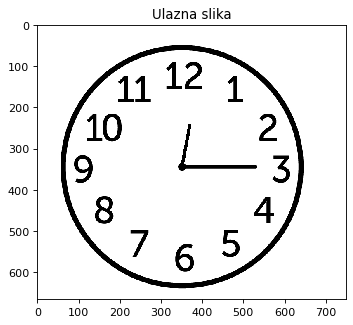

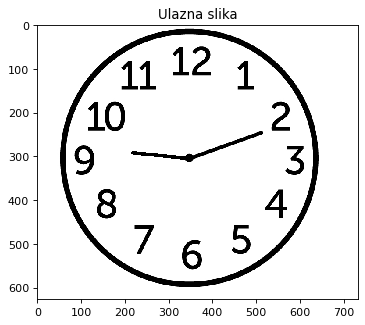

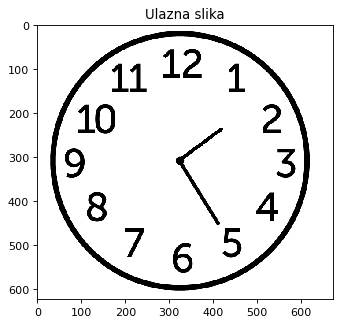

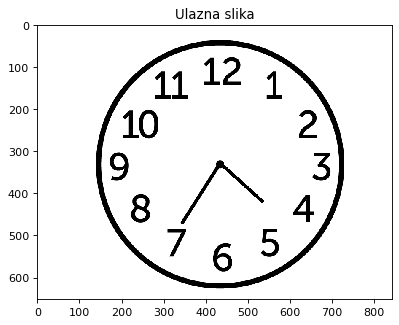

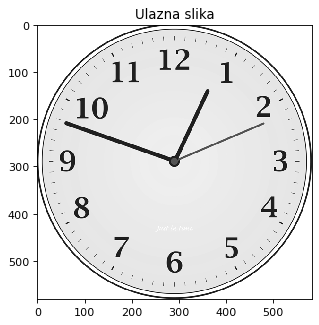

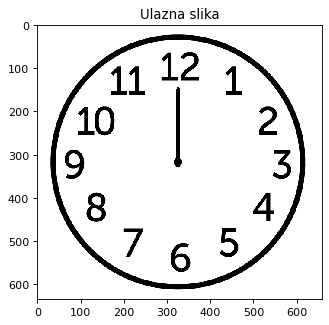

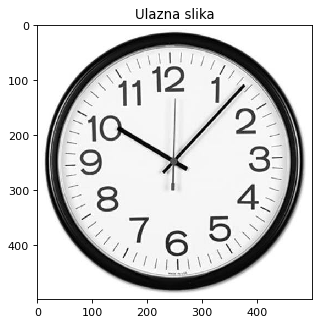

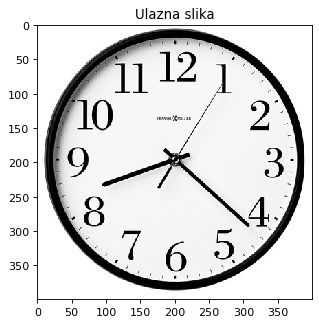

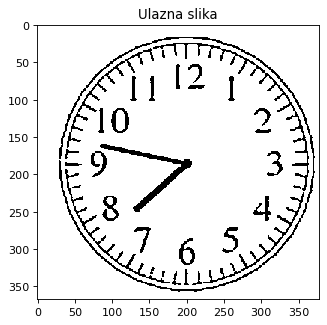

In [11]:
dirs = os.listdir('../sekvence/clocks/')
for file in dirs:
    img_in = imread('../sekvence/clocks/' + file)
    img_in = color.rgb2gray(img_in)
    img_in = skimage.img_as_float(img_in)
    plt.figure(figsize=(6,4), dpi=80)
    io.imshow(img_in, cmap = 'gray'); plt.title('Ulazna slika') 
    print(extract_time(img_in))

# Zadatak 2

U ovom zadatku treba klasifikovati novčiće od 1 i od 5 dinara. Pošto je pozadina karakteristične boje i saturacije više od saturacije novčića, prvo sam prebacio u HSV kolor sistem. Koristio sam Otsu-ovu granicu kako bih podelio nijansu. Pošto je pozadina skroz drugačije nijanse od nijanse novčića ovo nije bio problem (videće se kasnije na histogramu). Pošto saturacija nije separabilna kao nijansa, tu nisam mogao da koristim Otsu-ovu granicu, nego sam koristio 0.1 kao granicu. Za novčiće koji su loše klasifikovani nijansom ovo je dobra karakteristika za dalju klasifikaciju. Pošto neki novčići imaju rupe dalje sam radio tako što sam proširio masku, pa je onda skupio kako bi te rupice nestale. Možda bi bilo bolje da sam provukao kroz median filtar, ali sam želeo ovo da probam i dobijam dobre rezultate. 

In [12]:
from pylab import *
import skimage
from skimage import io
from skimage import filters
from skimage import color
from scipy import ndimage
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from tabulate import tabulate

Text(0.5, 1.0, 'Krajnja maska')

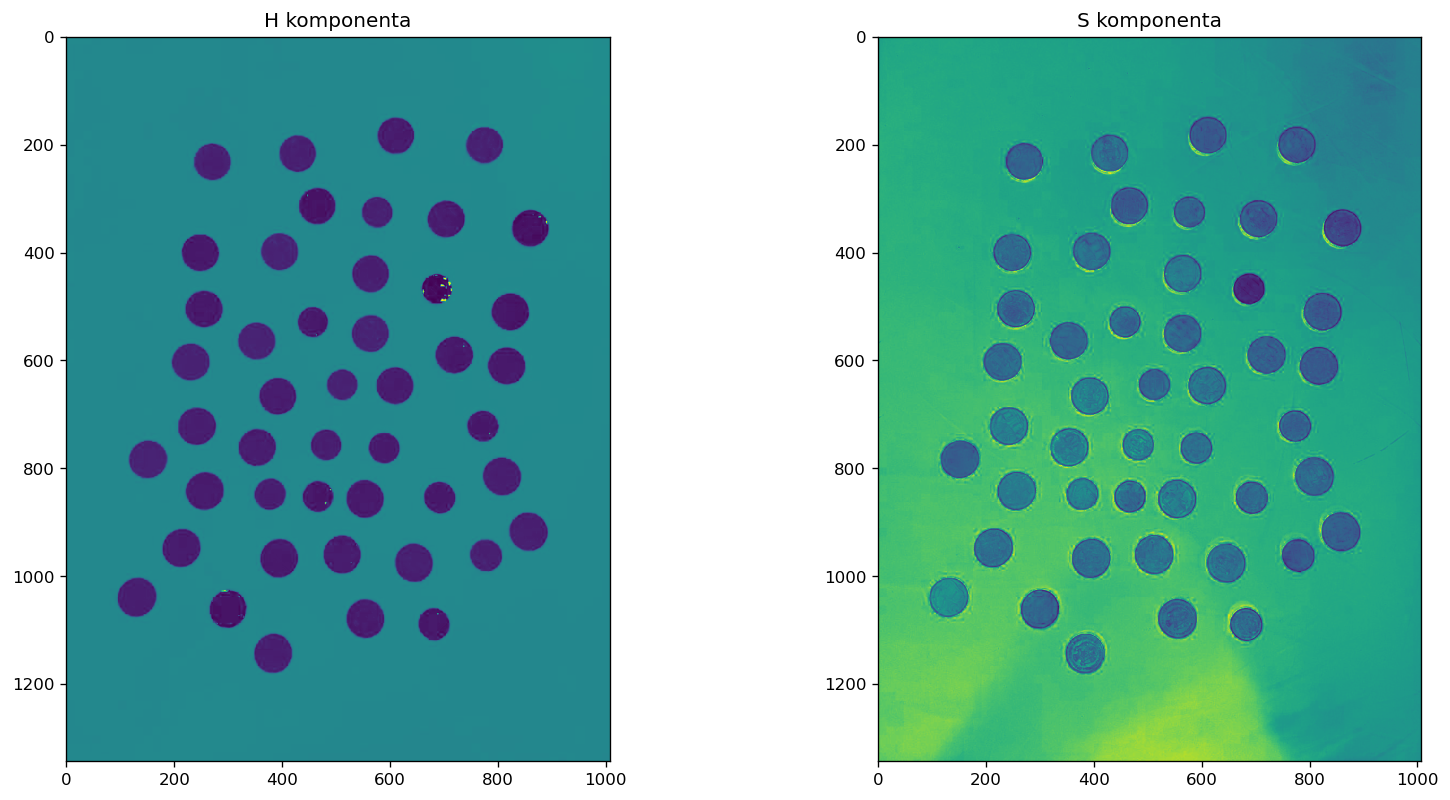

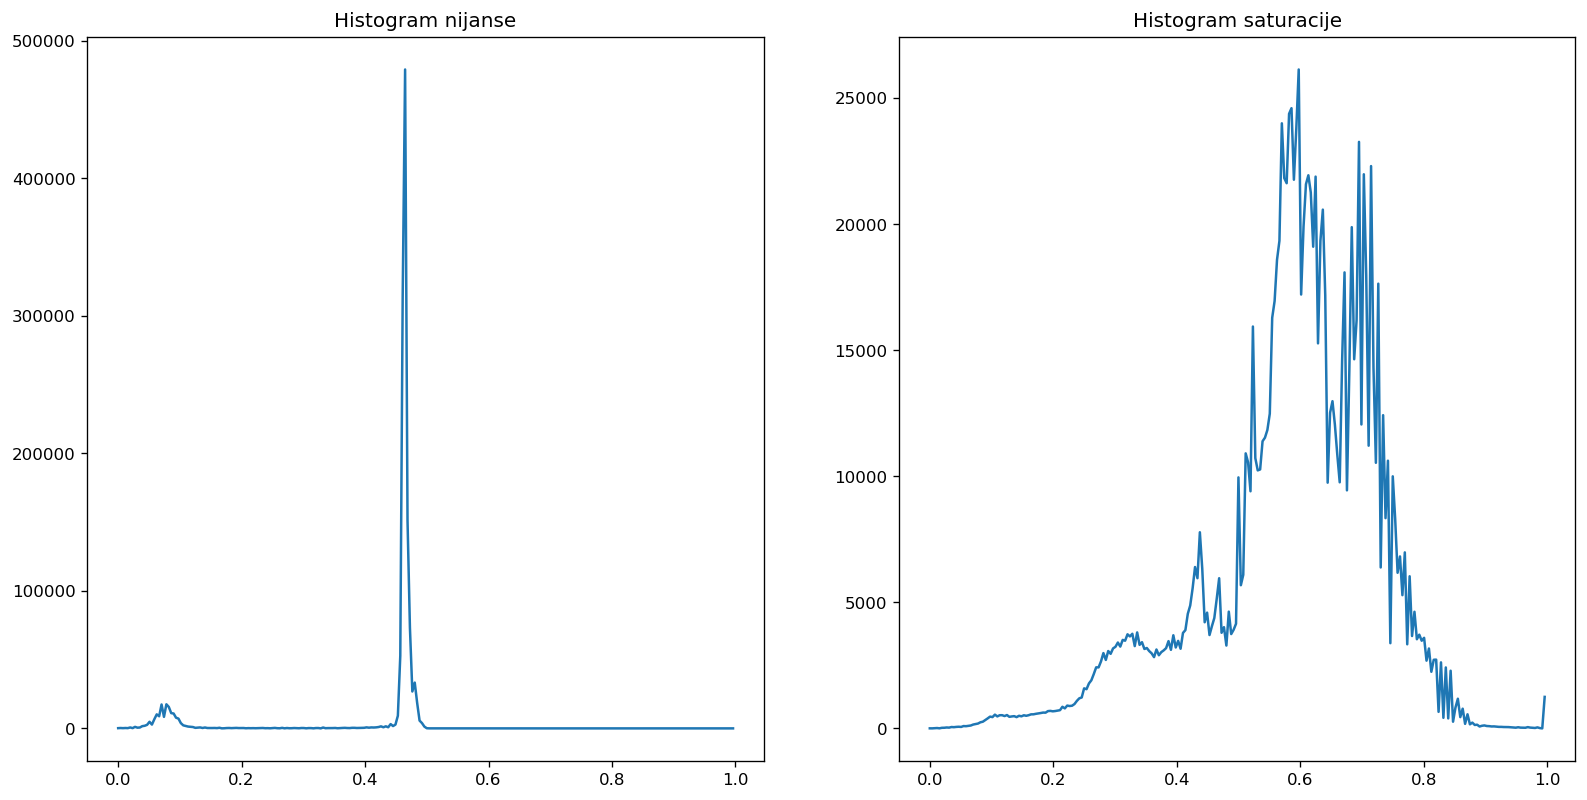

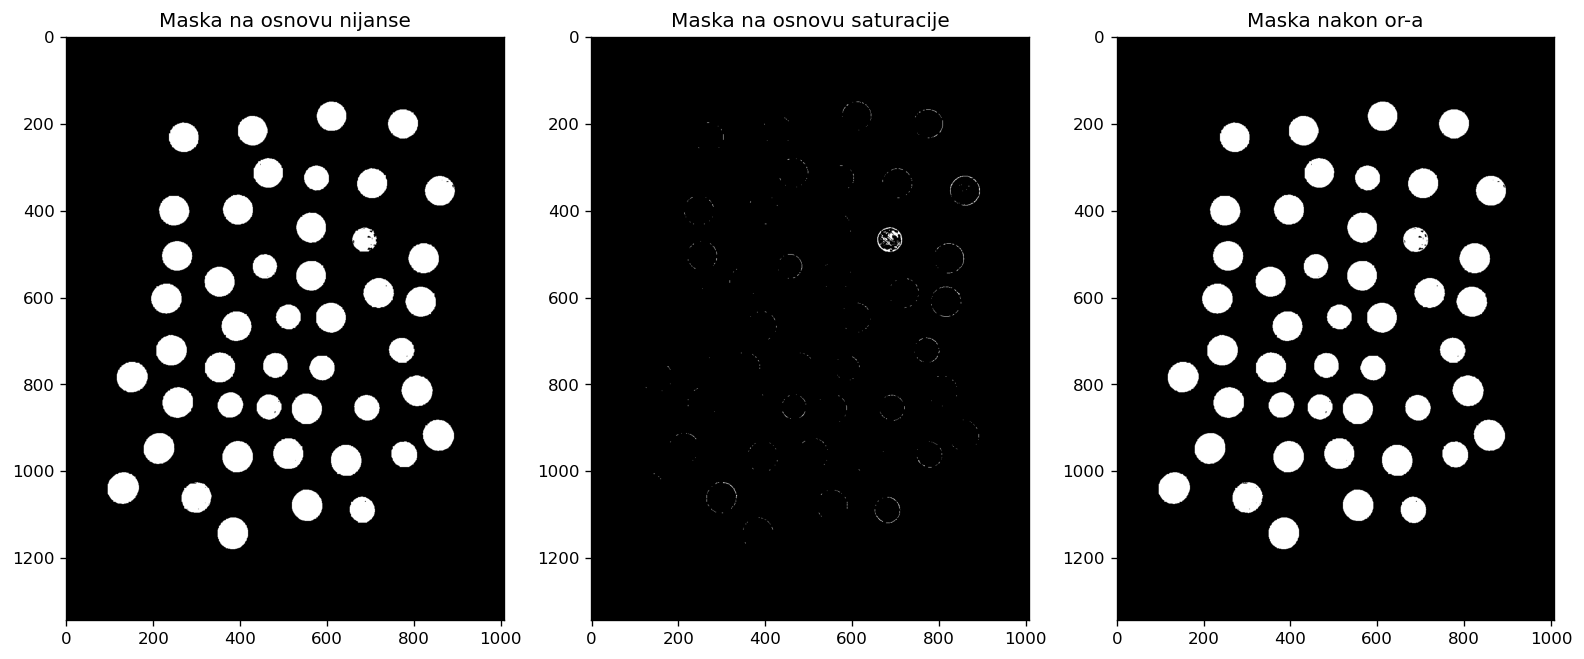

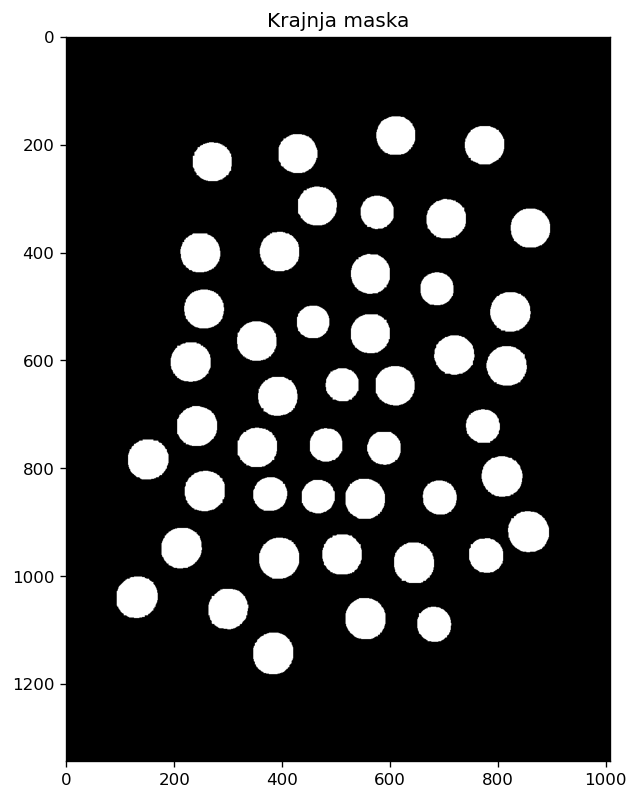

In [13]:
img_in = imread('../sekvence/coins/coins1.jpg')
img_hsv = color.rgb2hsv(img_in)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(img_hsv[:, :, 0]); ax[0].set_title('H komponenta');
ax[1].imshow(img_hsv[:, :, 1]); ax[1].set_title('S komponenta');

histogram_h, bin_h = np.histogram(img_hsv[:, :, 0].flatten(), bins=256, range=(0,1))
histogram_s, bin_s = np.histogram(img_hsv[:, :, 1].flatten(), bins=256, range=(0,1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].plot(bin_h[0:-1], histogram_h); ax[0].set_title('Histogram nijanse');
ax[1].plot(bin_s[0:-1], histogram_s); ax[1].set_title('Histogram saturacije');

# 2 classes are separated (which we can see from the histogram)
otsu_h = filters.threshold_otsu(img_hsv[:, :, 0])

mask_h = img_hsv[:, :, 0] < otsu_h

# when it comes to saturation otsu is not the best option,
# because we can not see the exact separation between 
# classes on histogram
mask_s = img_hsv[:, :, 1] < 0.1

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=120)
ax = axes.ravel()
ax[0].imshow(mask_h*1.0, cmap='gray'); ax[0].set_title('Maska na osnovu nijanse')
ax[1].imshow(mask_s*1.0, cmap='gray'); ax[1].set_title('Maska na osnovu saturacije')

mask = logical_or(mask_h, mask_s)
ax[2].imshow(mask*1.0, cmap='gray'); ax[2].set_title('Maska nakon or-a')

# making mask wider, to get rid of the holes in coin mask.
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
mask = ndimage.correlate(mask, kernel)
mask = mask>0

# making mask narrower, to keep the shape of coins
mask = ndimage.correlate(mask, kernel)
mask = mask==1

plt.figure(figsize=(16,8), dpi=120);
plt.imshow(mask*1.0, cmap='gray'); plt.title('Krajnja maska')

Naredna funkcija coin_mask radi istu stvar kao deo koda iznad, samo bez plotova, da se ne bi svaki put plotovalo sve.

In [14]:
def coin_mask(img_in: np.array) -> np.array:
    img_hsv = color.rgb2hsv(img_in)
    
    histogram_h, bin_h = np.histogram(img_hsv[:, :, 0].flatten(), bins=256, range=(0,1))
    histogram_s, bin_s = np.histogram(img_hsv[:, :, 1].flatten(), bins=256, range=(0,1))
    
    # 2 classes are separated (which we can see from the histogram)
    otsu_h = filters.threshold_otsu(img_hsv[:, :, 0])
    mask_h = img_hsv[:, :, 0] < otsu_h
    
    # when it comes to saturation otsu is not the best option,
    # because we can not see the exact separation between 
    # classes on histogram
    mask_s = img_hsv[:, :, 1] < 0.1
    mask = logical_or(mask_h, mask_s)
    
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    mask = ndimage.correlate(mask, kernel)
    mask = mask>0
    
    mask = ndimage.correlate(mask, kernel)
    return mask==1

Labele sam pravio tako što sam prolazio kroz sve piksele i proveravao gornja tri susedna piksela i piksel levo kako bih proverio da li oni pripadaju nekoj labeli. Ukoliko pripadaju, trenutnom pikselu dodeljujem vrednost te labele, a ukoliko ne onda pravim novu lebelu za trenutni piksel. Ukoliko 2 okolna piksela imaju različite labele onda ih odmah postavljam na istu. Naravno, sve ovo radim ukoliko piksel pripada novčiću u okviru maske koja je izlaz funkcije coin_mask.

In [15]:
def bw_label(img_bin: np.array) -> np.array:
    label = np.zeros(img_bin.shape, dtype=int)
    last_ind = 1
    for_equal = []
    
    for i in range(1, img_bin.shape[0]-1):
        for j in range(1, img_bin.shape[1]-1):
            if img_bin[i, j]==True:
                if label[i-1, j-1] != 0:
                    label[i, j] = label[i-1, j-1]
                    
                if label[i-1, j] != 0 and label[i-1, j] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i-1, j]] = label[i, j]
                    else:
                        label[i, j] = label[i-1, j]
                        
                if label[i-1, j+1] != 0 and label[i-1, j+1] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i-1, j+1]] = label[i, j]
                    else:
                        label[i, j] = label[i-1, j+1]
                
                if label[i, j-1] != 0 and label[i, j-1] != label[i,j]:
                    if label[i, j] != 0:
                        label[label==label[i, j-1]] = label[i, j]
                    else:
                        label[i, j] = label[i, j-1]
                    
                if label[i, j] == 0:
                    label[i, j] = last_ind
                    last_ind = last_ind+1
    return label

U sledećem delu koda pokazujem kako radi ova funkcija. Različite labele sam obojio drugom bojom.

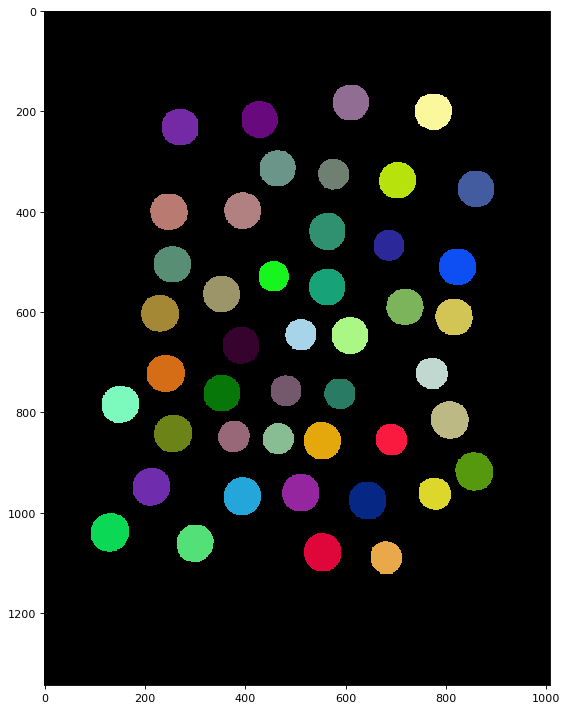

In [16]:
mask = coin_mask(img_in)
label = bw_label(mask)
random.seed(10)
    
img_colored = np.zeros((label.shape[0], label.shape[1], 3), dtype=float)

for i in range(1, np.max(label)):
    r = random.random()
    g = random.random()
    b = random.random()
    img_colored[label == i, 0] = r
    img_colored[label == i, 1] = g
    img_colored[label == i, 2] = b

plt.figure(figsize=(12, 9), dpi=80)
io.imshow(img_colored)

U funkciji coin_classification sam samo pozvao obe funkcije coin_mask i bw_label. Nakon toga sam izbrojao koliko ima elemenata iz svake labele i na osnovu broja piksela koji pripadaju labeli sam klasifikovao novčiće. Za granični broj sam koristio otsu-ovu granicu. Takođe predstavio sam sliku gde prikazujem novčiće koji su klasifikovani u klasu 1 (crveni) i u klasu 2 (zeleni).

In [17]:
def coin_classification(img_in: np.array) -> tuple:
    mask = coin_mask(img_in)
    label = bw_label(mask)
    
    maks = np.max(label)
    hist = np.zeros(maks, dtype=int)
    for i in range(1, maks+1):
        hist[i-1] = np.sum(label==i)
    ind = hist>0
    otsu = filters.threshold_otsu(hist[ind])
    r1 = 0.7
    g1 = 0.2
    b1 = 0.2
    
    r2 = 0.2
    g2 = 0.7
    b2 = 0.2
    img_out = np.zeros((label.shape[0], label.shape[1], 3), dtype=float)
    
    for i in range(1, maks+1):
        img = label == i
        suma = np.sum(img)
        if suma != 0 and suma <=otsu:
            img_out[img, 0] = r1
            img_out[img, 1] = g1
            img_out[img, 2] = b1
        if suma>otsu:
            img_out[img, 0] = r2
            img_out[img, 1] = g2
            img_out[img, 2] = b2
            
    ax[1].imshow(img_out); ax[1].set_title('Klasifikacija novčića');
    
    return np.sum(hist[ind]<=otsu), np.sum(hist[ind]>otsu)

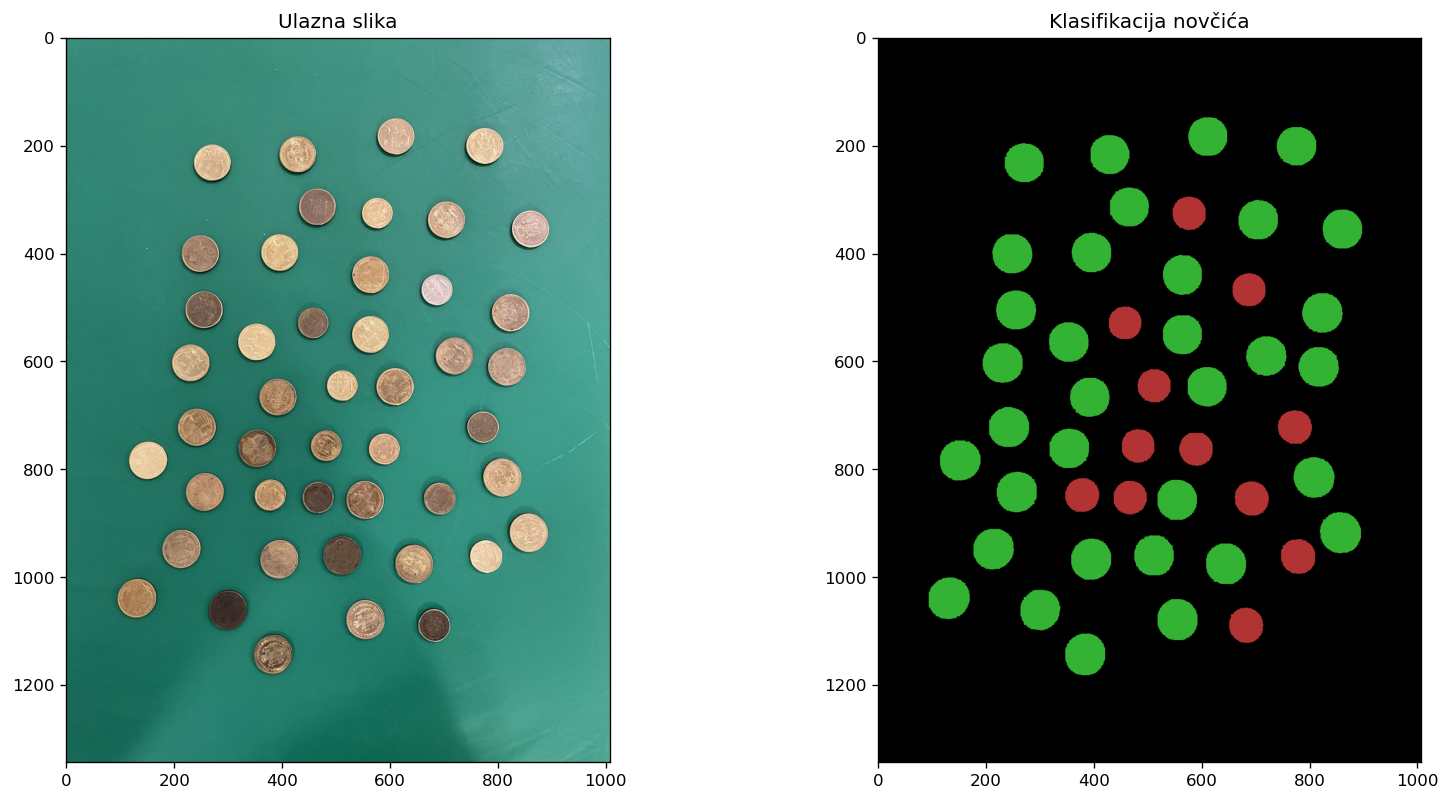

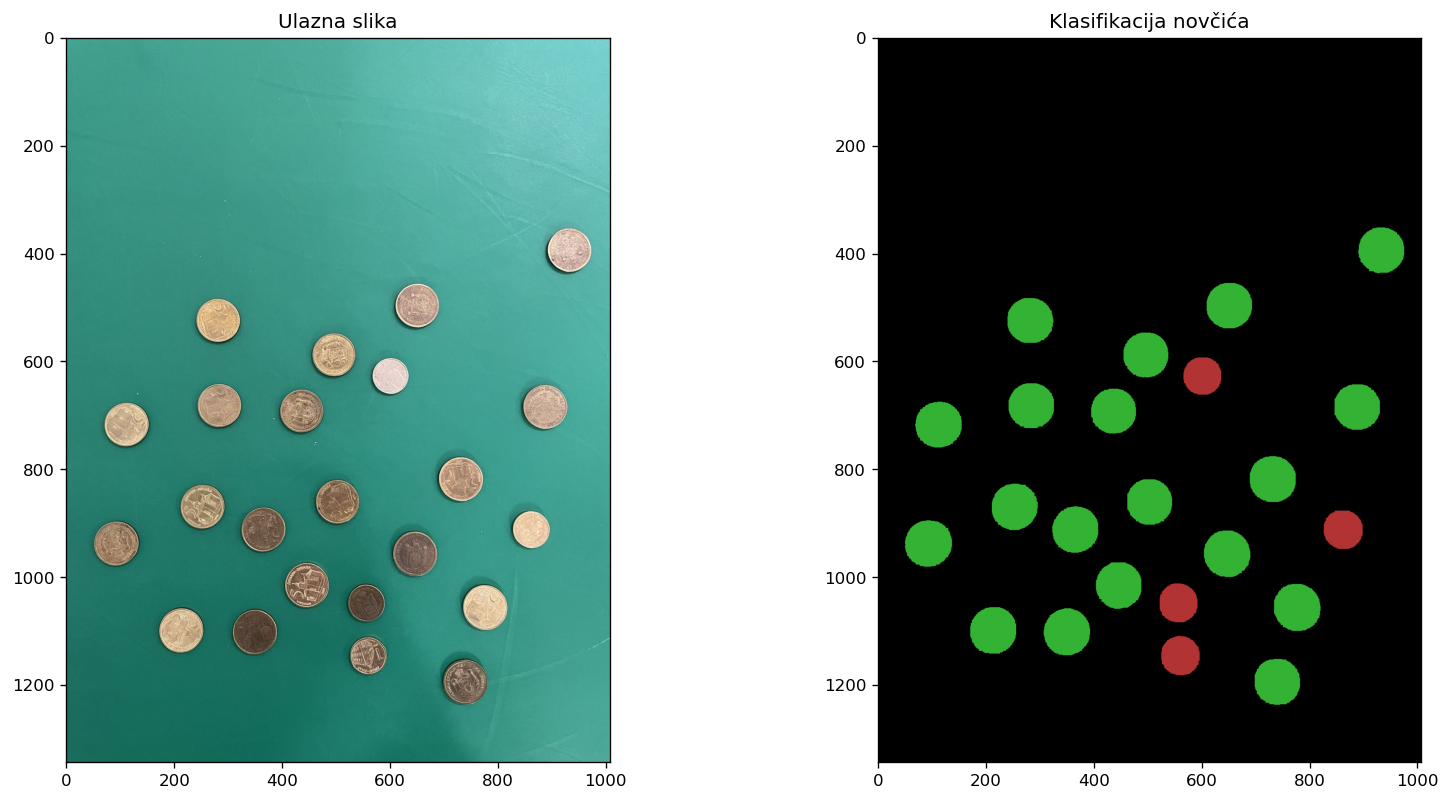

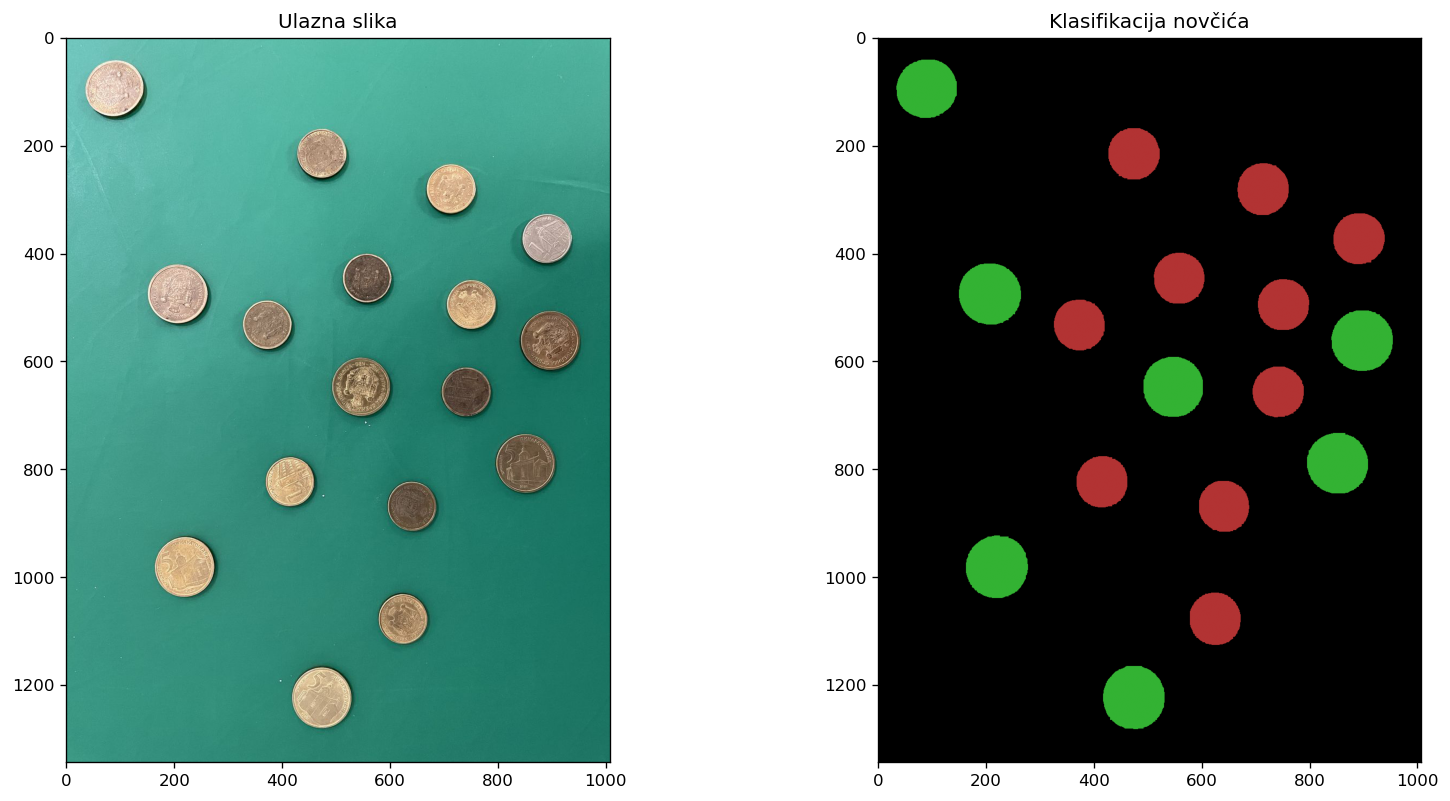

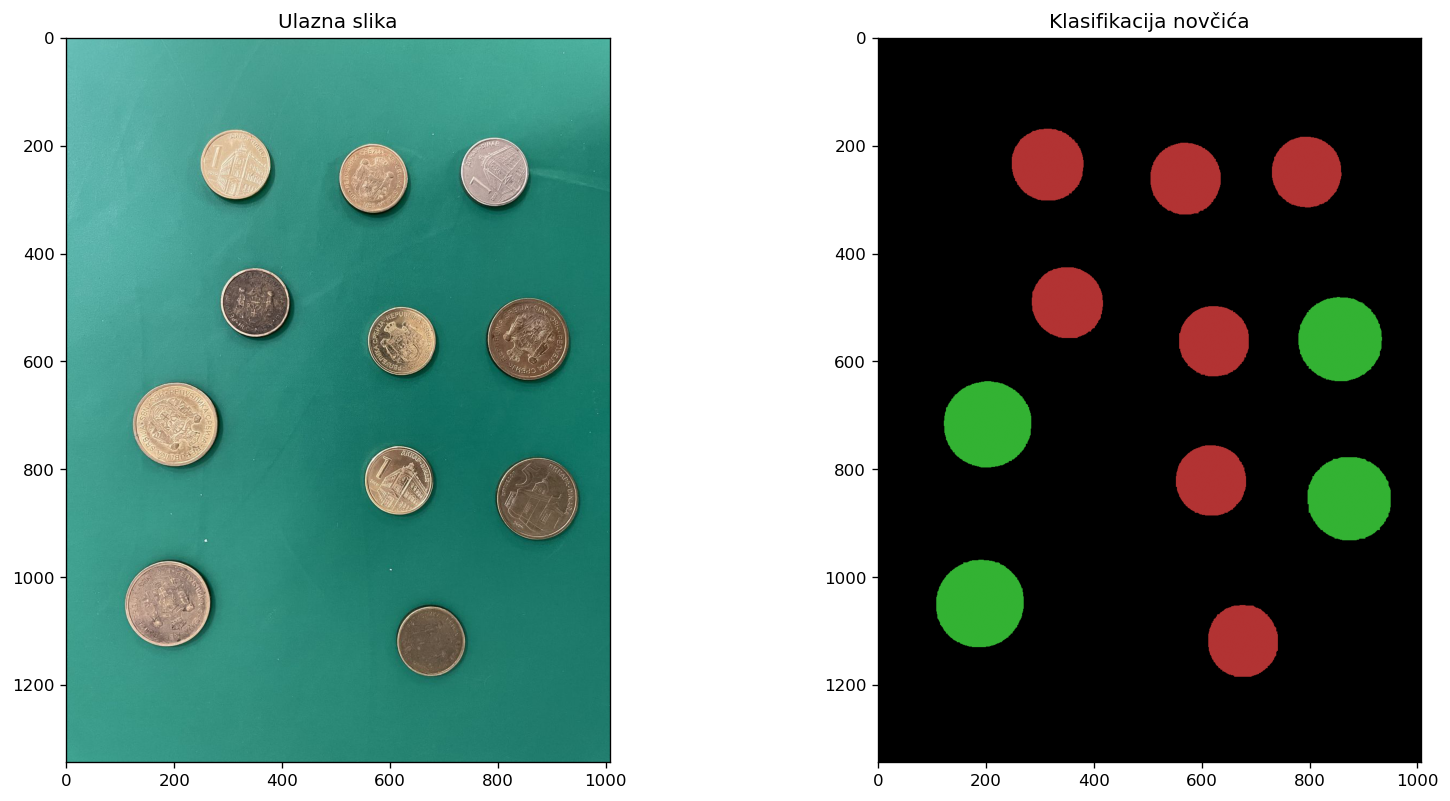

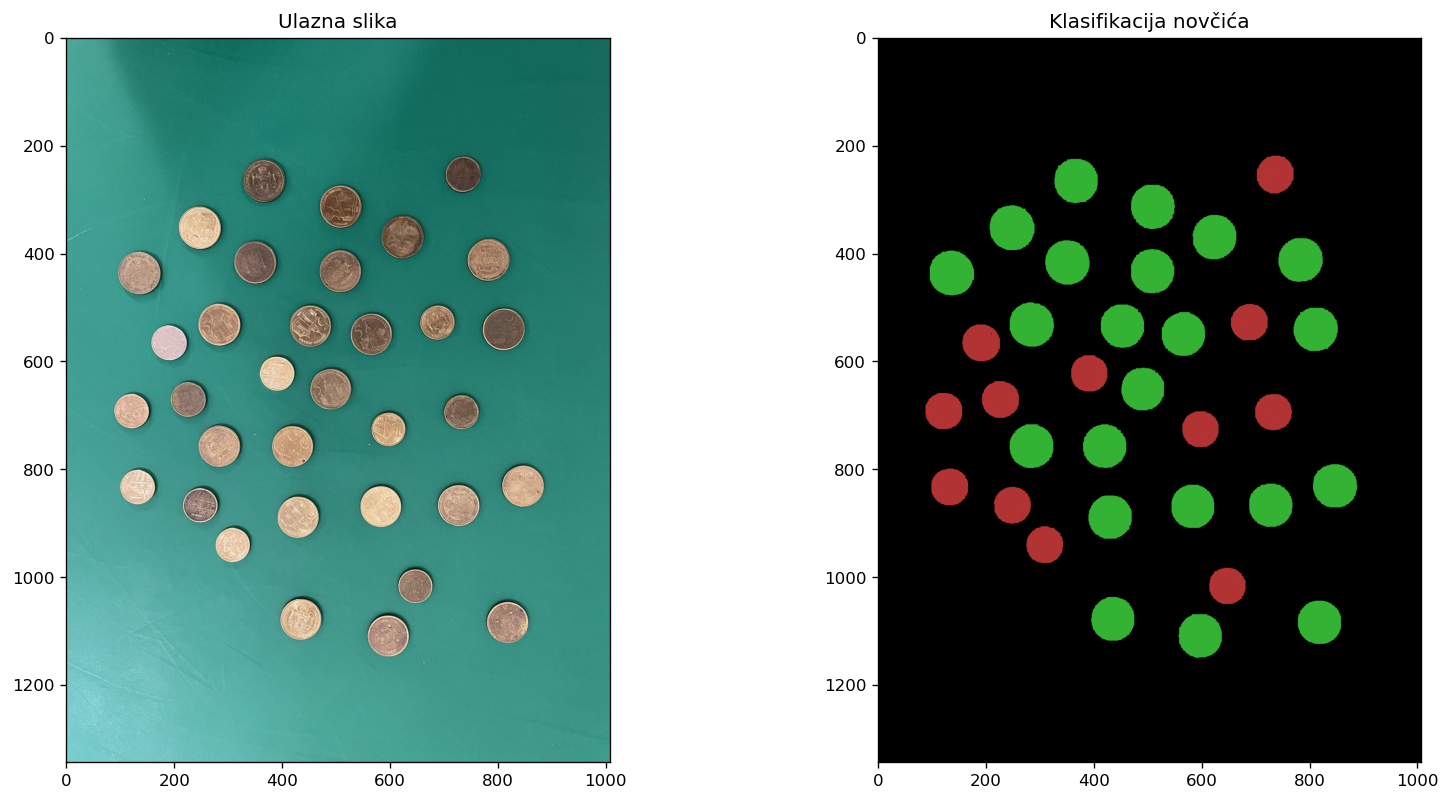

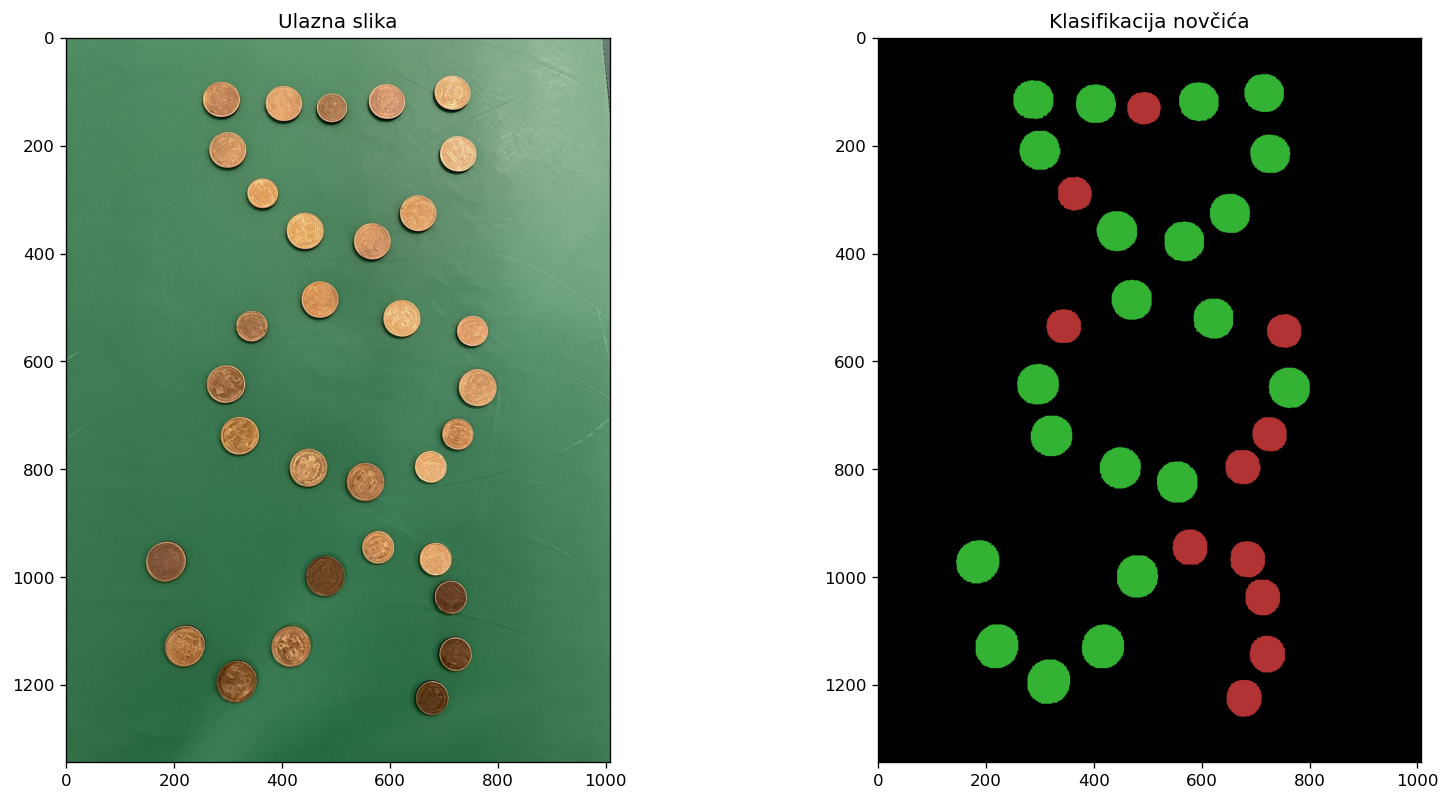

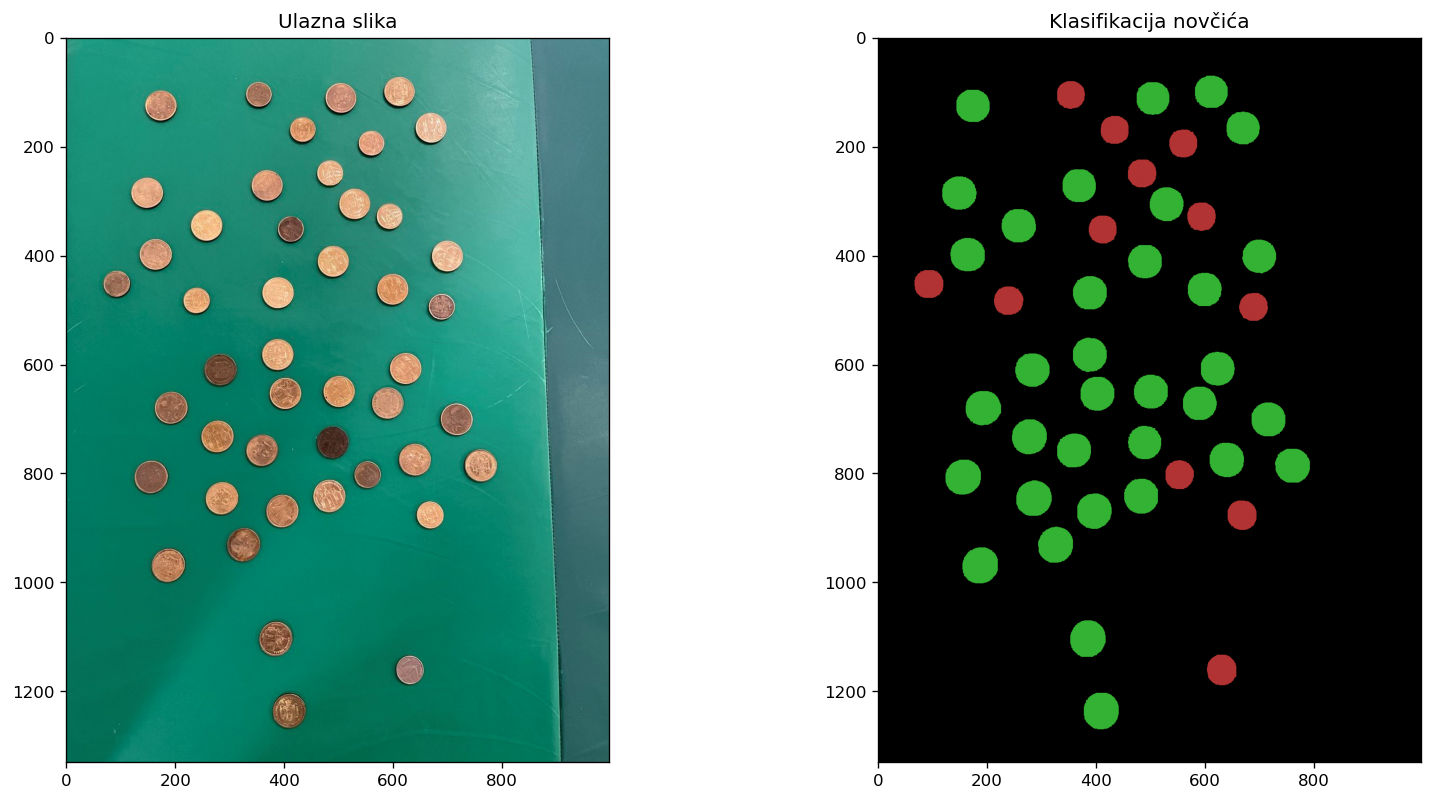

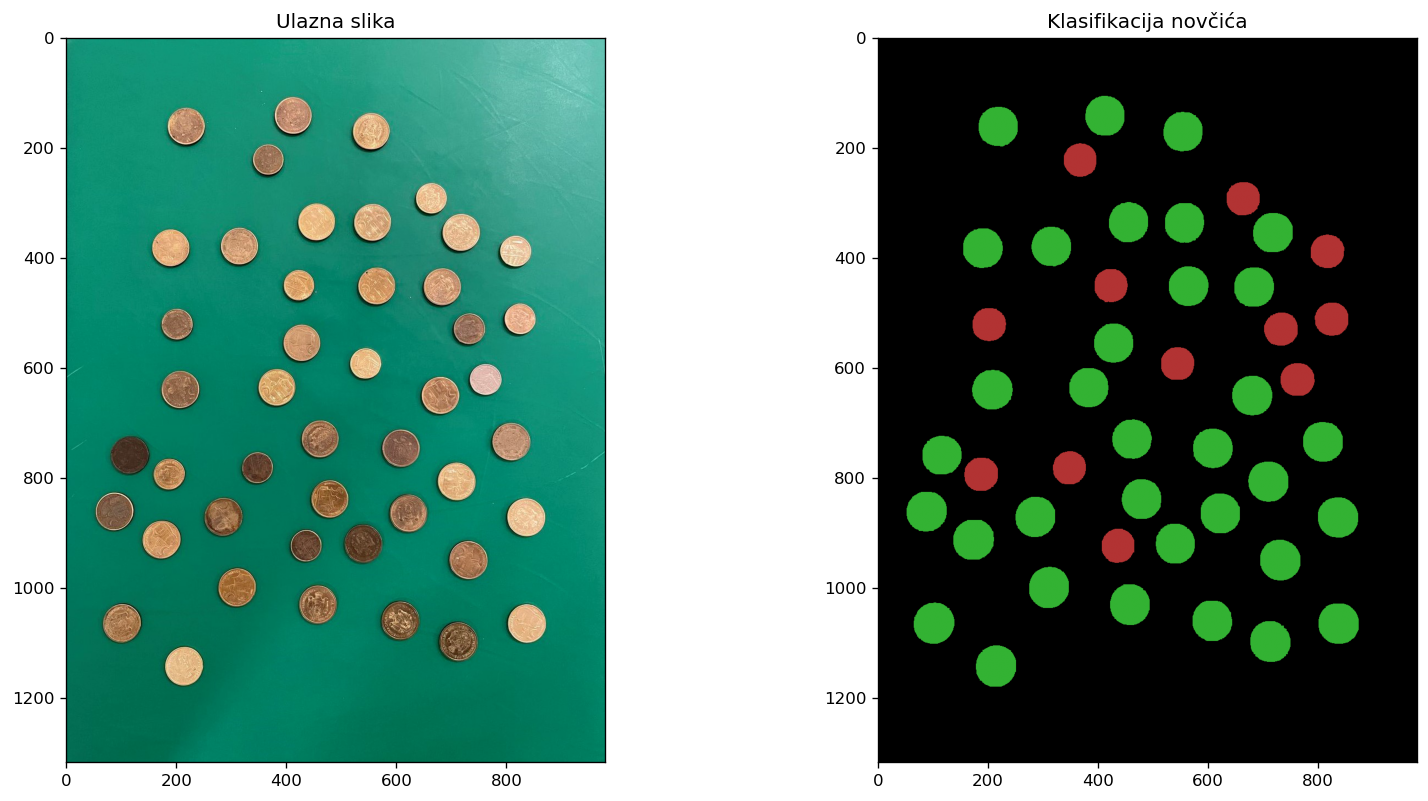

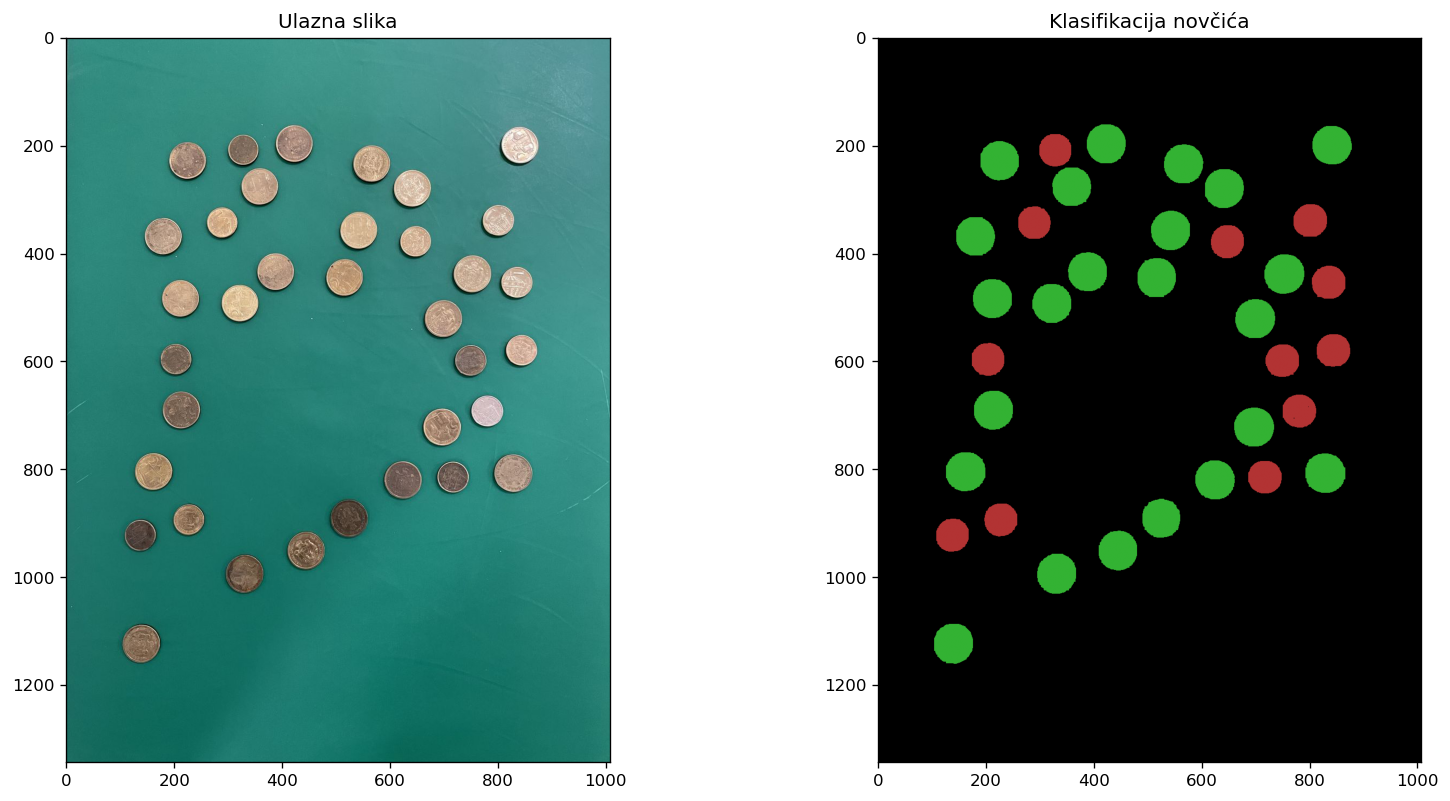

In [18]:
file_path = '../sekvence/coins/coins'
table =[['Slika', 'Klasa 1', 'Klasa 2', 'Ukupno']]
for image_num in range(1, 10):
    name = file_path + str(image_num) + '.jpg'
    img_in = imread(name)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), dpi=120)
    ax = axes.ravel()
    ax[0].imshow(img_in); ax[0].set_title('Ulazna slika');
    k1, k2 = coin_classification(img_in)
    table = table + [['coins' + str(image_num) + '.jpg', str(k1), str(k2), str(k1+k2)]]

Evo prikaza rezultata nad svim slikama i kao što vidimo rezultati su dobri na svim slikama.

In [19]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤═══════════╤═══════════╤══════════╕
│ Slika      │   Klasa 1 │   Klasa 2 │   Ukupno │
╞════════════╪═══════════╪═══════════╪══════════╡
│ coins1.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins2.jpg │         4 │        19 │       23 │
├────────────┼───────────┼───────────┼──────────┤
│ coins3.jpg │        10 │         7 │       17 │
├────────────┼───────────┼───────────┼──────────┤
│ coins4.jpg │         7 │         4 │       11 │
├────────────┼───────────┼───────────┼──────────┤
│ coins5.jpg │        12 │        22 │       34 │
├────────────┼───────────┼───────────┼──────────┤
│ coins6.jpg │        11 │        21 │       32 │
├────────────┼───────────┼───────────┼──────────┤
│ coins7.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins8.jpg │        12 │        34 │       46 │
├────────────┼───────────┼───────────┼──────────┤
│ coins9.jpg │        12 │        23 │       35 │
